In [1]:
#!/usr/bin/env python3
import logging
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score

# --- Config ---------------------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s"
)
log = logging.getLogger(__name__)

DATA_PATH = Path(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv")
TARGET_COL = "Group"
RANDOM_STATE = 42

# Feature families and their suffix variants
BASES = [
    "Frac_Extreme_X", "Max_Dwell_Time", "Mean_Dwell_Time",
    "Regression_Transition_Ratio_Count", "Mean_Window_Entropy", "Entropy_Deviation",
    "Fixation_Deviation_Variance", "State_Occupancy_Entropy", "Self_Transition_Ratio_Count",
]
SUFFIXES = ["std", "mean", "median", "skew", "kurtosis_func"]

# SVM hyperparameter grid
GRID_PARAMS = {
    "clf__kernel": ["linear", "rbf"],
    "clf__C": [0.1, 1, 10, 100],
    "clf__gamma": ["scale", "auto"],
}

# VIF threshold for collinearity filtering
VIF_THRESHOLD = 10.0


def iterative_vif_filter(df: pd.DataFrame, cols: list[str], thresh: float):
    """
    Iteratively remove features with VIF > thresh.
    Operates only on df[cols].
    Returns a list of surviving columns.
    """
    kept = cols.copy()
    while True:
        sub = df[kept].dropna()
        Xc = sm.add_constant(sub)
        vifs = [variance_inflation_factor(Xc.values, i + 1) for i in range(len(kept))]
        max_vif = max(vifs)
        max_feat = kept[vifs.index(max_vif)]
        if max_vif <= thresh:
            break
        log.info("Dropping %s (VIF=%.1f)", max_feat, max_vif)
        kept.remove(max_feat)
    return kept


def select_variants(train_df: pd.DataFrame, y: np.ndarray):
    """
    On training data only, performs:
      1) VIF filtering
      2) Global suffix initialization (_std if available)
      3) Wrapper-style per-family variant selection
    Returns final list of feature names.
    """
    # 1) candidate variants present in train
    all_vars = [f"{b}_{s}" for b in BASES for s in SUFFIXES if f"{b}_{s}" in train_df]
    # 2) VIF filtering
    survivors = iterative_vif_filter(train_df, all_vars, VIF_THRESHOLD)
    # 3) group by family
    family_variants = {b: [v for v in survivors if v.startswith(b + "_")] for b in BASES}
    families = [b for b, lst in family_variants.items() if lst]
    # 4) initiate to _std if exists
    current = {b: (f"{b}_std" if f"{b}_std" in family_variants[b] else family_variants[b][0])
               for b in families}
    # 5) wrapper selection
    improved = True
    while improved:
        improved = False
        for b in families:
            fixed = [current[f] for f in families if f != b]
            best_auc, best_var = -np.inf, current[b]
            for cand in family_variants[b]:
                X_try = train_df[fixed + [cand]].values
                grid = GridSearchCV(
                    Pipeline([
                        ("scaler", PowerTransformer(method="yeo-johnson")),
                        ("clf", SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE)),
                    ]),
                    GRID_PARAMS, scoring="roc_auc",
                    cv=StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE),
                    n_jobs=-1, refit=False,
                )
                score = grid.fit(X_try, y).best_score_
                if score > best_auc + 1e-4:
                    best_auc, best_var = score, cand
            if best_var != current[b]:
                log.info("Updating family %s: %s → %s (AUC=%.3f)", b, current[b], best_var, best_auc)
                current[b] = best_var
                improved = True
    return list(current.values())


def main():
    df = pd.read_csv(DATA_PATH)
    le = LabelEncoder().fit(df[TARGET_COL])
    y = le.transform(df[TARGET_COL])

    outer_cv = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    aucs = []
    selections = []  # store features per fold

    # outer CV: feature selection + tuning + evaluation
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(df, y), 1):
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        selected = select_variants(train_df, y_train)
        log.info("Fold %d selected features: %s", fold, selected)
        selections.append(selected)

        # hyperparameter tuning
        X_train = train_df[selected].values
        grid = GridSearchCV(
            Pipeline([
                ("scaler", PowerTransformer(method="yeo-johnson")),
                ("clf", SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE)),
            ]),
            GRID_PARAMS, scoring="roc_auc",
            cv=StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE),
            n_jobs=-1, refit=True,
        )
        grid.fit(X_train, y_train)
        best = grid.best_estimator_
        log.info("Fold %d best params: %s", fold, grid.best_params_)

        # evaluate
        X_test = test_df[selected].values
        y_prob = best.predict_proba(X_test)[:, 1]
        fold_auc = roc_auc_score(y_test, y_prob)
        aucs.append(fold_auc)
        print(f"Fold {fold} test AUC: {fold_auc:.3f}")

    # summary
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs, ddof=1)
    print(f"\nOuter CV mean AUC: {mean_auc:.3f} ± {std_auc:.3f}")

    # Final recommended feature set (consensus mode)
    FINAL_FEATURES = [
        "Frac_Extreme_X_std",
        "Entropy_Deviation_kurtosis_func",
        "Max_Dwell_Time_median",
        "Regression_Transition_Ratio_Count_kurtosis_func",
        "Mean_Window_Entropy_median",
        "Fixation_Deviation_Variance_kurtosis_func",
        "State_Occupancy_Entropy_std",
        "Self_Transition_Ratio_Count_mean",
    ]
    print("\n=== Final feature set applied ===")
    for f in FINAL_FEATURES:
        print(f, end="  ")

    # Retrain on full data with final features
    X_full = df[FINAL_FEATURES].values
    pipeline = Pipeline([
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("clf", SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE)),
    ])
    grid_final = GridSearchCV(
        pipeline, GRID_PARAMS, scoring="roc_auc",
        cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE),
        n_jobs=-1, refit=True,
    )
    grid_final.fit(X_full, y)
    final_auc = np.mean(
        grid_final.cv_results_["mean_test_score"][
            grid_final.cv_results_["params"].index(grid_final.best_params_)
        ]
    )
    print(f"\nFinal model estimated AUC: {final_auc:.3f}")

if __name__ == "__main__":
    main()


2025-05-09 18:00:13,479 INFO Dropping Mean_Dwell_Time_mean (VIF=24612.6)
2025-05-09 18:00:13,566 INFO Dropping Self_Transition_Ratio_Count_median (VIF=1762.1)
2025-05-09 18:00:13,654 INFO Dropping Mean_Window_Entropy_mean (VIF=795.0)
2025-05-09 18:00:13,739 INFO Dropping Mean_Dwell_Time_skew (VIF=667.2)
2025-05-09 18:00:13,820 INFO Dropping Regression_Transition_Ratio_Count_mean (VIF=553.4)
2025-05-09 18:00:13,895 INFO Dropping State_Occupancy_Entropy_mean (VIF=420.9)
2025-05-09 18:00:13,965 INFO Dropping Fixation_Deviation_Variance_mean (VIF=278.6)
2025-05-09 18:00:14,034 INFO Dropping Entropy_Deviation_mean (VIF=258.5)
2025-05-09 18:00:14,096 INFO Dropping Mean_Dwell_Time_median (VIF=251.2)
2025-05-09 18:00:14,160 INFO Dropping Frac_Extreme_X_mean (VIF=119.5)
2025-05-09 18:00:14,223 INFO Dropping Mean_Dwell_Time_std (VIF=113.3)
2025-05-09 18:00:14,284 INFO Dropping Mean_Dwell_Time_kurtosis_func (VIF=36.0)
2025-05-09 18:00:14,340 INFO Dropping Max_Dwell_Time_mean (VIF=35.6)
2025-05-09

Fold 1 test AUC: 0.510


2025-05-09 18:01:00,631 INFO Dropping Self_Transition_Ratio_Count_median (VIF=1179.9)
2025-05-09 18:01:00,716 INFO Dropping Mean_Dwell_Time_skew (VIF=755.1)
2025-05-09 18:01:00,800 INFO Dropping Regression_Transition_Ratio_Count_mean (VIF=449.2)
2025-05-09 18:01:00,880 INFO Dropping State_Occupancy_Entropy_median (VIF=406.3)
2025-05-09 18:01:00,954 INFO Dropping Mean_Dwell_Time_median (VIF=364.9)
2025-05-09 18:01:01,022 INFO Dropping Entropy_Deviation_mean (VIF=266.5)
2025-05-09 18:01:01,090 INFO Dropping Fixation_Deviation_Variance_mean (VIF=261.3)
2025-05-09 18:01:01,151 INFO Dropping Frac_Extreme_X_mean (VIF=134.8)
2025-05-09 18:01:01,217 INFO Dropping Mean_Dwell_Time_kurtosis_func (VIF=111.4)
2025-05-09 18:01:01,277 INFO Dropping Mean_Dwell_Time_std (VIF=88.1)
2025-05-09 18:01:01,338 INFO Dropping Max_Dwell_Time_mean (VIF=40.1)
2025-05-09 18:01:01,386 INFO Dropping Fixation_Deviation_Variance_skew (VIF=27.0)
2025-05-09 18:01:01,436 INFO Dropping Entropy_Deviation_median (VIF=13.8)


Fold 2 test AUC: 0.540


2025-05-09 18:01:25,032 INFO Dropping Mean_Window_Entropy_mean (VIF=849.3)
2025-05-09 18:01:25,114 INFO Dropping Mean_Dwell_Time_skew (VIF=644.8)
2025-05-09 18:01:25,197 INFO Dropping Regression_Transition_Ratio_Count_mean (VIF=627.3)
2025-05-09 18:01:25,273 INFO Dropping Mean_Dwell_Time_median (VIF=304.3)
2025-05-09 18:01:25,346 INFO Dropping State_Occupancy_Entropy_mean (VIF=273.0)
2025-05-09 18:01:25,416 INFO Dropping Entropy_Deviation_mean (VIF=263.3)
2025-05-09 18:01:25,480 INFO Dropping Frac_Extreme_X_mean (VIF=190.3)
2025-05-09 18:01:25,539 INFO Dropping Fixation_Deviation_Variance_mean (VIF=183.1)
2025-05-09 18:01:25,599 INFO Dropping Mean_Dwell_Time_std (VIF=125.6)
2025-05-09 18:01:25,681 INFO Dropping Mean_Dwell_Time_kurtosis_func (VIF=45.8)
2025-05-09 18:01:25,744 INFO Dropping Max_Dwell_Time_mean (VIF=37.2)
2025-05-09 18:01:25,795 INFO Dropping Fixation_Deviation_Variance_skew (VIF=25.2)
2025-05-09 18:01:25,846 INFO Dropping Entropy_Deviation_median (VIF=14.3)
2025-05-09 18

Fold 3 test AUC: 0.490


2025-05-09 18:02:01,738 INFO Dropping Mean_Window_Entropy_median (VIF=901.5)
2025-05-09 18:02:01,823 INFO Dropping Regression_Transition_Ratio_Count_mean (VIF=683.5)
2025-05-09 18:02:01,908 INFO Dropping Mean_Dwell_Time_skew (VIF=628.8)
2025-05-09 18:02:01,989 INFO Dropping Fixation_Deviation_Variance_mean (VIF=442.0)
2025-05-09 18:02:02,069 INFO Dropping Mean_Dwell_Time_median (VIF=360.0)
2025-05-09 18:02:02,141 INFO Dropping State_Occupancy_Entropy_mean (VIF=331.7)
2025-05-09 18:02:02,206 INFO Dropping Entropy_Deviation_mean (VIF=285.8)
2025-05-09 18:02:02,267 INFO Dropping Frac_Extreme_X_mean (VIF=107.9)
2025-05-09 18:02:02,333 INFO Dropping Mean_Dwell_Time_std (VIF=98.4)
2025-05-09 18:02:02,394 INFO Dropping Max_Dwell_Time_mean (VIF=43.3)
2025-05-09 18:02:02,455 INFO Dropping Mean_Dwell_Time_kurtosis_func (VIF=28.6)
2025-05-09 18:02:02,503 INFO Dropping Fixation_Deviation_Variance_skew (VIF=23.6)
2025-05-09 18:02:02,552 INFO Dropping Entropy_Deviation_median (VIF=14.2)
2025-05-09 1

Fold 4 test AUC: 0.560


2025-05-09 18:02:38,790 INFO Dropping Mean_Window_Entropy_mean (VIF=951.9)
2025-05-09 18:02:38,869 INFO Dropping Mean_Dwell_Time_skew (VIF=824.4)
2025-05-09 18:02:38,950 INFO Dropping Fixation_Deviation_Variance_mean (VIF=486.8)
2025-05-09 18:02:39,024 INFO Dropping Mean_Dwell_Time_median (VIF=403.9)
2025-05-09 18:02:39,094 INFO Dropping Regression_Transition_Ratio_Count_median (VIF=365.8)
2025-05-09 18:02:39,167 INFO Dropping Entropy_Deviation_mean (VIF=261.0)
2025-05-09 18:02:39,240 INFO Dropping State_Occupancy_Entropy_mean (VIF=230.3)
2025-05-09 18:02:39,307 INFO Dropping Frac_Extreme_X_median (VIF=120.3)
2025-05-09 18:02:39,372 INFO Dropping Mean_Dwell_Time_std (VIF=116.1)
2025-05-09 18:02:39,431 INFO Dropping Mean_Dwell_Time_kurtosis_func (VIF=41.6)
2025-05-09 18:02:39,485 INFO Dropping Max_Dwell_Time_mean (VIF=33.3)
2025-05-09 18:02:39,532 INFO Dropping Fixation_Deviation_Variance_skew (VIF=26.9)
2025-05-09 18:02:39,583 INFO Dropping Fixation_Deviation_Variance_median (VIF=10.7)

Fold 5 test AUC: 0.590

Outer CV mean AUC: 0.538 ± 0.040

=== Final feature set applied ===
Frac_Extreme_X_std  Entropy_Deviation_kurtosis_func  Max_Dwell_Time_median  Regression_Transition_Ratio_Count_kurtosis_func  Mean_Window_Entropy_median  Fixation_Deviation_Variance_kurtosis_func  State_Occupancy_Entropy_std  Self_Transition_Ratio_Count_mean  
Final model estimated AUC: 0.692


In [11]:
#!/usr/bin/env python3
import logging
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score

# --- Config ---------------------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s"
)
log = logging.getLogger(__name__)

DATA_PATH = Path(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output1001.csv")
TARGET_COL = "Group"
RANDOM_STATE = 42

# Feature families and their suffix variants
BASES = [
    "r", "mt", "beta",
    "iota", "nu", 
]
SUFFIXES = ["std", "mean"]

# SVM hyperparameter grid
GRID_PARAMS = {
    "clf__kernel": ["linear", "rbf"],
    "clf__C": [0.1, 1, 10, 100],
    "clf__gamma": ["scale", "auto"],
}

# VIF threshold for collinearity filtering
VIF_THRESHOLD = 10.0


def iterative_vif_filter(df: pd.DataFrame, cols: list[str], thresh: float):
    """
    Iteratively remove features with VIF > thresh.
    Operates only on df[cols].
    Returns a list of surviving columns.
    """
    kept = cols.copy()
    while True:
        sub = df[kept].dropna()
        Xc = sm.add_constant(sub)
        vifs = [variance_inflation_factor(Xc.values, i + 1) for i in range(len(kept))]
        max_vif = max(vifs)
        max_feat = kept[vifs.index(max_vif)]
        if max_vif <= thresh:
            break
        log.info("Dropping %s (VIF=%.1f)", max_feat, max_vif)
        kept.remove(max_feat)
    return kept


def select_variants(train_df: pd.DataFrame, y: np.ndarray):
    """
    On training data only, performs:
      1) VIF filtering
      2) Global suffix initialization (_std if available)
      3) Wrapper-style per-family variant selection
    Returns final list of feature names.
    """
    # 1) candidate variants present in train
    all_vars = [f"{b}_{s}" for b in BASES for s in SUFFIXES if f"{b}_{s}" in train_df]
    # 2) VIF filtering
    survivors = iterative_vif_filter(train_df, all_vars, VIF_THRESHOLD)
    # 3) group by family
    family_variants = {b: [v for v in survivors if v.startswith(b + "_")] for b in BASES}
    families = [b for b, lst in family_variants.items() if lst]
    # 4) initiate to _std if exists
    current = {b: (f"{b}_std" if f"{b}_std" in family_variants[b] else family_variants[b][0])
               for b in families}
    # 5) wrapper selection
    improved = True
    while improved:
        improved = False
        for b in families:
            fixed = [current[f] for f in families if f != b]
            best_auc, best_var = -np.inf, current[b]
            for cand in family_variants[b]:
                X_try = train_df[fixed + [cand]].values
                grid = GridSearchCV(
                    Pipeline([
                        ("scaler", PowerTransformer(method="yeo-johnson")),
                        ("clf", SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE)),
                    ]),
                    GRID_PARAMS, scoring="roc_auc",
                    cv=StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE),
                    n_jobs=-1, refit=False,
                )
                score = grid.fit(X_try, y).best_score_
                if score > best_auc + 1e-4:
                    best_auc, best_var = score, cand
            if best_var != current[b]:
                log.info("Updating family %s: %s → %s (AUC=%.3f)", b, current[b], best_var, best_auc)
                current[b] = best_var
                improved = True
    return list(current.values())


def main():
    df = pd.read_csv(DATA_PATH)
    le = LabelEncoder().fit(df[TARGET_COL])
    y = le.transform(df[TARGET_COL])

    outer_cv = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    aucs = []
    selections = []  # store features per fold

    # outer CV: feature selection + tuning + evaluation
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(df, y), 1):
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        selected = select_variants(train_df, y_train)
        log.info("Fold %d selected features: %s", fold, selected)
        selections.append(selected)

        # hyperparameter tuning
        X_train = train_df[selected].values
        grid = GridSearchCV(
            Pipeline([
                ("scaler", PowerTransformer(method="yeo-johnson")),
                ("clf", SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE)),
            ]),
            GRID_PARAMS, scoring="roc_auc",
            cv=StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE),
            n_jobs=-1, refit=True,
        )
        grid.fit(X_train, y_train)
        best = grid.best_estimator_
        log.info("Fold %d best params: %s", fold, grid.best_params_)

        # evaluate
        X_test = test_df[selected].values
        y_prob = best.predict_proba(X_test)[:, 1]
        fold_auc = roc_auc_score(y_test, y_prob)
        aucs.append(fold_auc)
        print(f"Fold {fold} test AUC: {fold_auc:.3f}")

    # summary
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs, ddof=1)
    print(f"\nOuter CV mean AUC: {mean_auc:.3f} ± {std_auc:.3f}")

    # Final recommended feature set (consensus mode)
    FINAL_FEATURES = [
        "Frac_Extreme_X_std",
        "Entropy_Deviation_kurtosis_func",
        "Max_Dwell_Time_median",
        "Regression_Transition_Ratio_Count_kurtosis_func",
        "Mean_Window_Entropy_median",
        "Fixation_Deviation_Variance_kurtosis_func",
        "State_Occupancy_Entropy_std",
        "Self_Transition_Ratio_Count_mean",
    ]
    print("\n=== Final feature set applied ===")
    for f in FINAL_FEATURES:
        print(f, end="  ")

    # Retrain on full data with final features
    X_full = df[FINAL_FEATURES].values
    pipeline = Pipeline([
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("clf", SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE)),
    ])
    grid_final = GridSearchCV(
        pipeline, GRID_PARAMS, scoring="roc_auc",
        cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE),
        n_jobs=-1, refit=True,
    )
    grid_final.fit(X_full, y)
    final_auc = np.mean(
        grid_final.cv_results_["mean_test_score"][
            grid_final.cv_results_["params"].index(grid_final.best_params_)
        ]
    )
    print(f"\nFinal model estimated AUC: {final_auc:.3f}")

if __name__ == "__main__":
    main()


2025-05-10 21:32:40,128 INFO Dropping beta_mean (VIF=24.1)
2025-05-10 21:32:40,141 INFO Dropping iota_std (VIF=14.1)
2025-05-10 21:32:40,156 INFO Dropping r_std (VIF=12.6)
2025-05-10 21:32:41,887 INFO Updating family nu: nu_std → nu_mean (AUC=0.701)
2025-05-10 21:32:43,922 INFO Fold 1 selected features: ['r_mean', 'mt_std', 'beta_std', 'iota_mean', 'nu_mean']
2025-05-10 21:32:44,290 INFO Fold 1 best params: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
2025-05-10 21:32:44,307 INFO Dropping beta_mean (VIF=23.4)
2025-05-10 21:32:44,322 INFO Dropping iota_std (VIF=13.5)
2025-05-10 21:32:44,333 INFO Dropping r_std (VIF=13.0)


Fold 1 test AUC: 0.630


2025-05-10 21:32:45,890 INFO Updating family nu: nu_std → nu_mean (AUC=0.572)
2025-05-10 21:32:47,580 INFO Fold 2 selected features: ['r_mean', 'mt_std', 'beta_std', 'iota_mean', 'nu_mean']
2025-05-10 21:32:47,927 INFO Fold 2 best params: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
2025-05-10 21:32:47,960 INFO Dropping beta_mean (VIF=22.0)
2025-05-10 21:32:47,973 INFO Dropping r_std (VIF=13.7)
2025-05-10 21:32:47,985 INFO Dropping iota_std (VIF=11.3)


Fold 2 test AUC: 0.675


2025-05-10 21:32:49,650 INFO Fold 3 selected features: ['r_mean', 'mt_std', 'beta_std', 'iota_mean', 'nu_std']
2025-05-10 21:32:49,964 INFO Fold 3 best params: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
2025-05-10 21:32:49,984 INFO Dropping beta_mean (VIF=23.5)
2025-05-10 21:32:49,997 INFO Dropping iota_std (VIF=12.5)
2025-05-10 21:32:50,009 INFO Dropping r_std (VIF=11.9)


Fold 3 test AUC: 0.415


2025-05-10 21:32:51,734 INFO Updating family nu: nu_std → nu_mean (AUC=0.620)
2025-05-10 21:32:52,424 INFO Updating family mt: mt_std → mt_mean (AUC=0.631)
2025-05-10 21:32:54,928 INFO Fold 4 selected features: ['r_mean', 'mt_mean', 'beta_std', 'iota_mean', 'nu_mean']
2025-05-10 21:32:55,241 INFO Fold 4 best params: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
2025-05-10 21:32:55,262 INFO Dropping beta_mean (VIF=33.4)
2025-05-10 21:32:55,278 INFO Dropping iota_std (VIF=14.2)
2025-05-10 21:32:55,289 INFO Dropping r_std (VIF=13.1)


Fold 4 test AUC: 0.600


2025-05-10 21:32:56,819 INFO Updating family nu: nu_std → nu_mean (AUC=0.653)
2025-05-10 21:32:58,545 INFO Fold 5 selected features: ['r_mean', 'mt_std', 'beta_std', 'iota_mean', 'nu_mean']
2025-05-10 21:32:58,947 INFO Fold 5 best params: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}


Fold 5 test AUC: 0.750

Outer CV mean AUC: 0.614 ± 0.125

=== Final feature set applied ===
Frac_Extreme_X_std  Entropy_Deviation_kurtosis_func  Max_Dwell_Time_median  Regression_Transition_Ratio_Count_kurtosis_func  Mean_Window_Entropy_median  Fixation_Deviation_Variance_kurtosis_func  State_Occupancy_Entropy_std  Self_Transition_Ratio_Count_mean  

KeyError: "['Entropy_Deviation_kurtosis_func'] not in index"

2025-05-09 18:13:48,706 INFO Loading data from D:\ACIT Master's Thesis\New data\Colab_eyetracking\stories\new_version03\merged_output100.csv
2025-05-09 18:13:58,622 INFO Baseline (all 19) features AUC: 0.712


Baseline AUC (all features): 0.712


2025-05-09 18:15:44,703 INFO Removed 'Fixation_Deviation_Variance_std', new AUC: 0.800


Removed 'Fixation_Deviation_Variance_std', AUC: 0.800


2025-05-09 18:17:09,300 INFO Removed 'Mean_Window_Entropy_median', new AUC: 0.812


Removed 'Mean_Window_Entropy_median', AUC: 0.812


2025-05-09 18:18:24,909 INFO Removed 'iota_mean', new AUC: 0.820


Removed 'iota_mean', AUC: 0.820


2025-05-09 18:19:35,830 INFO Removed 'Regression_Transition_Ratio_Count_kurtosis_func', new AUC: 0.822


Removed 'Regression_Transition_Ratio_Count_kurtosis_func', AUC: 0.822


2025-05-09 18:20:37,817 INFO Removed 'Entropy_Deviation_kurtosis_func', new AUC: 0.830


Removed 'Entropy_Deviation_kurtosis_func', AUC: 0.830


2025-05-09 18:21:32,859 INFO Removed 'mean_fixation_duration_median', new AUC: 0.852


Removed 'mean_fixation_duration_median', AUC: 0.852


2025-05-09 18:22:20,913 INFO No removal improved AUC; stopping.



Final selected features:
 - Max_Dwell_Time_median
 - Frac_Extreme_X_std
 - State_Occupancy_Entropy_std
 - Fixation_Deviation_Variance_kurtosis_func
 - mean_saccade_amplitude_std
 - nu_mean
 - mt_std
 - beta_std
 - r_mean
 - totaltime_exp
 - gazedur_exp
 - std_saccade_velocity_skew
 - Self_Transition_Ratio_Count_mean
Final AUC: 0.852


C:\Users\MEHRAN\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Best hyperparameters:
  clf__C: 100
  clf__gamma: scale
  clf__kernel: linear


C:\Users\MEHRAN\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\MEHRAN\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\MEHRAN\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\MEHRAN\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning:


Classification Report:
              precision    recall  f1-score   support

        ADHD       0.79      0.76      0.78        50
          TD       0.77      0.80      0.78        50

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100



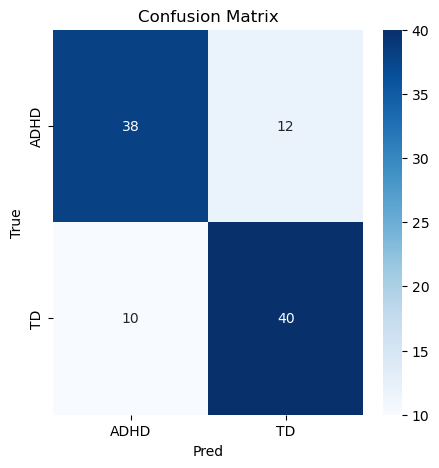

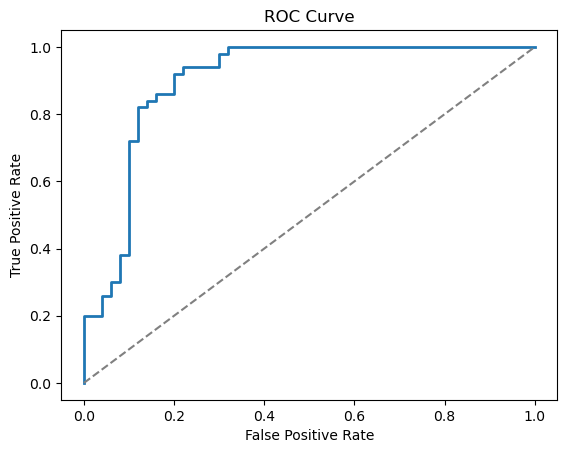

In [2]:
#!/usr/bin/env python3
import argparse, logging
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

# ── logging ───────────────────────────────────────────────────────────────────
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# ── data I/O ───────────────────────────────────────────────────────────────────
def load_data(path: Path, features: list[str], target: str) -> pd.DataFrame:
    logger.info(f"Loading data from {path}")
    df = pd.read_csv(path)
    missing = set(features + [target]) - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    return df

# ── baseline nested‐CV AUC for a given feature subset ─────────────────────────
def nested_auc(X: np.ndarray, y: np.ndarray, random_state=42) -> float:
    outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("smote", SMOTE(random_state=random_state)),
        ("clf", SVC(probability=True, class_weight="balanced", random_state=random_state))
    ])
    grid = GridSearchCV(
        pipe,
        {
            "clf__kernel": ["linear", "rbf"],
            "clf__C": [0.1, 1, 10, 100],
            "clf__gamma": ["scale", "auto"]
        },
        scoring="roc_auc", cv=inner, n_jobs=-1, refit=True
    )
    scores = cross_val_score(grid, X, y, cv=outer, scoring="roc_auc", n_jobs=-1)
    return float(scores.mean())

# ── backward sequential feature elimination ──────────────────────────────────
def backward_sfs(df: pd.DataFrame, features: list[str], target: str):
    # Encode target
    le = LabelEncoder().fit(df[target])
    y = le.transform(df[target])
    current_feats = features.copy()

    # Compute baseline AUC with all features
    X_full = df[current_feats].values
    best_auc = nested_auc(X_full, y)
    logger.info(f"Baseline (all {len(current_feats)}) features AUC: {best_auc:.3f}")
    print(f"Baseline AUC (all features): {best_auc:.3f}")

    history = [(current_feats.copy(), best_auc)]

    # Iteratively remove one feature that maximizes AUC
    while len(current_feats) > 1:
        auc_scores = {}
        for feat in current_feats:
            trial_feats = [f for f in current_feats if f != feat]
            X_trial = df[trial_feats].values
            auc_scores[feat] = nested_auc(X_trial, y)
        # find feature whose removal gives highest AUC
        remove_feat, remove_auc = max(auc_scores.items(), key=lambda x: x[1])
        if remove_auc >= best_auc:
            current_feats.remove(remove_feat)
            best_auc = remove_auc
            logger.info(f"Removed '{remove_feat}', new AUC: {best_auc:.3f}")
            print(f"Removed '{remove_feat}', AUC: {best_auc:.3f}")
            history.append((current_feats.copy(), best_auc))
        else:
            # stop if no removal improves AUC
            logger.info("No removal improved AUC; stopping.")
            break

    print("\nFinal selected features:")
    for f in current_feats:
        print(f" - {f}")
    print(f"Final AUC: {best_auc:.3f}")
    return current_feats, history, le

# ── evaluation with final subset ──────────────────────────────────────────────
def evaluate_final(df: pd.DataFrame, selected_feats: list[str], target: str, le: LabelEncoder):
    X = df[selected_feats].values
    y = le.transform(df[target])
    # Fit final model using best hyperparams from nested inner CV
    # (reuse nested_auc pipeline but refit on full data)
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("smote", SMOTE(random_state=42)),
        ("clf", SVC(probability=True, class_weight="balanced", random_state=42))
    ])
    grid = GridSearchCV(
        pipe,
        {"clf__kernel": ["linear", "rbf"],
         "clf__C": [0.1, 1, 10, 100],
         "clf__gamma": ["scale", "auto"]},
        scoring="roc_auc", cv=StratifiedKFold(3, shuffle=True, random_state=42),
        n_jobs=-1, refit=True
    )
    grid.fit(X, y)
    best = grid.best_estimator_
    print("\nBest hyperparameters:")
    for k,v in grid.best_params_.items(): print(f"  {k}: {v}")

    # CV predictions
    cv = StratifiedKFold(5, shuffle=True, random_state=42)
    y_prob = cross_val_score(grid, X, y, cv=cv, scoring="roc_auc")  # for AUC
    # For classification report / confusion, use cross_val_predict
    from sklearn.model_selection import cross_val_predict
    y_pred = cross_val_predict(best, X, y, cv=cv)

    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.show()

    fpr, tpr, _ = roc_curve(y, grid.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()

# ── main ─────────────────────────────────────────────────────────────────────
def main():
    p = argparse.ArgumentParser()
    p.add_argument("--data-path", type=str)
    args, _ = p.parse_known_args()

    data_path = Path(args.data_path) if args.data_path else Path(
        r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv"
    )

    FEATURES = [
     "Max_Dwell_Time_median",
  
    'Mean_Window_Entropy_median',
        
        "Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
   'Fixation_Deviation_Variance_kurtosis_func', "mean_saccade_amplitude_std",'Fixation_Deviation_Variance_std',
    "nu_mean",  "mt_std", "beta_std",'r_mean','iota_mean',
    "totaltime_exp", 'gazedur_exp',
    "std_saccade_velocity_skew", "mean_fixation_duration_median",
    "Self_Transition_Ratio_Count_mean", "Entropy_Deviation_kurtosis_func", 'Regression_Transition_Ratio_Count_kurtosis_func'
    ]
    TARGET = "Group"

    df = load_data(data_path, FEATURES, TARGET)
    selected_feats, history, le = backward_sfs(df, FEATURES, TARGET)
    evaluate_final(df, selected_feats, TARGET, le)

if __name__ == "__main__":
    main()




2025-05-11 00:12:44,862 INFO Loading data from D:\ACIT Master's Thesis\New data\Colab_eyetracking\stories\new_version03\merged_output1000.csv
2025-05-11 00:12:52,661 INFO Baseline (all 19) features AUC: 0.768


Baseline AUC (all features): 0.768


2025-05-11 00:14:34,684 INFO Removed 'Mean_Window_Entropy_median', new AUC: 0.800


Removed 'Mean_Window_Entropy_median', AUC: 0.800


2025-05-11 00:16:07,555 INFO Removed 'Max_Dwell_Time_median', new AUC: 0.814


Removed 'Max_Dwell_Time_median', AUC: 0.814


2025-05-11 00:17:30,690 INFO No removal improved AUC; stopping.



Final selected features:
 - Frac_Extreme_X_std
 - State_Occupancy_Entropy_std
 - Fixation_Deviation_Variance_kurtosis_func
 - Fixation_Deviation_Variance_std
 - nu_mean
 - mt_sd
 - beta_sd
 - r_mean
 - iota_mean
 - totaltime_exp
 - gazedur_exp
 - Self_Transition_Ratio_Count_mean
 - Entropy_Deviation_kurtosis_func
 - Regression_Transition_Ratio_Count_kurtosis_func
 - mean_saccade_amplitude_std
 - std_saccade_velocity_std
 - mean_fixation_duration_mean
Final AUC: 0.814

Best hyperparameters:
  clf__C: 10
  clf__gamma: scale
  clf__kernel: linear

Classification Report:
              precision    recall  f1-score   support

        ADHD       0.75      0.72      0.73        50
          TD       0.73      0.76      0.75        50

    accuracy                           0.74       100
   macro avg       0.74      0.74      0.74       100
weighted avg       0.74      0.74      0.74       100



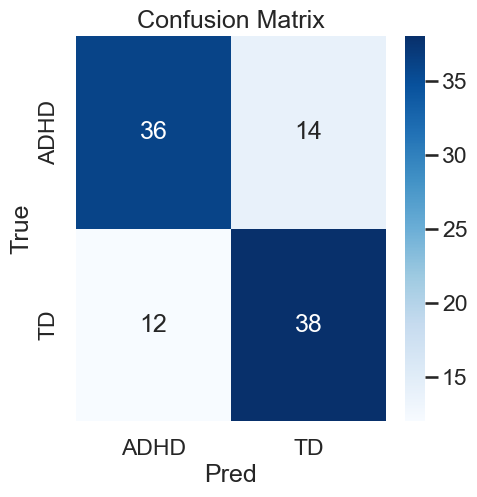

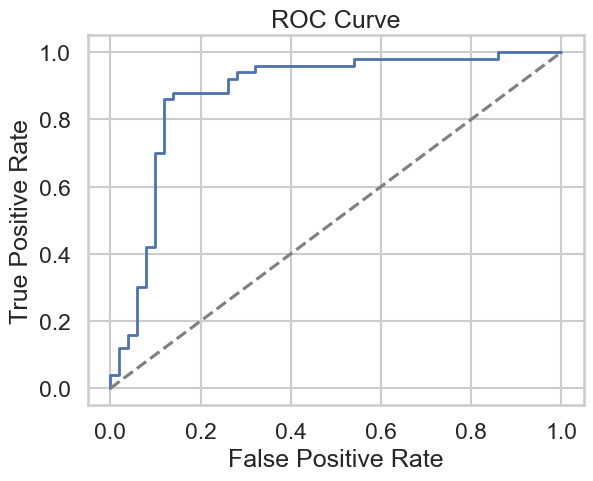

In [20]:
#!/usr/bin/env python3
import argparse, logging
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

# ── logging ───────────────────────────────────────────────────────────────────
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# ── data I/O ───────────────────────────────────────────────────────────────────
def load_data(path: Path, features: list[str], target: str) -> pd.DataFrame:
    logger.info(f"Loading data from {path}")
    df = pd.read_csv(path)
    missing = set(features + [target]) - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    return df

# ── baseline nested‐CV AUC for a given feature subset ─────────────────────────
def nested_auc(X: np.ndarray, y: np.ndarray, random_state=42) -> float:
    outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("smote", SMOTE(random_state=random_state)),
        ("clf", SVC(probability=True, class_weight="balanced", random_state=random_state))
    ])
    grid = GridSearchCV(
        pipe,
        {
            "clf__kernel": ["linear", "rbf"],
            "clf__C": [0.1, 1, 10, 100],
            "clf__gamma": ["scale", "auto"]
        },
        scoring="roc_auc", cv=inner, n_jobs=-1, refit=True
    )
    scores = cross_val_score(grid, X, y, cv=outer, scoring="roc_auc", n_jobs=-1)
    return float(scores.mean())

# ── backward sequential feature elimination ──────────────────────────────────
def backward_sfs(df: pd.DataFrame, features: list[str], target: str):
    # Encode target
    le = LabelEncoder().fit(df[target])
    y = le.transform(df[target])
    current_feats = features.copy()

    # Compute baseline AUC with all features
    X_full = df[current_feats].values
    best_auc = nested_auc(X_full, y)
    logger.info(f"Baseline (all {len(current_feats)}) features AUC: {best_auc:.3f}")
    print(f"Baseline AUC (all features): {best_auc:.3f}")

    history = [(current_feats.copy(), best_auc)]

    # Iteratively remove one feature that maximizes AUC
    while len(current_feats) > 1:
        auc_scores = {}
        for feat in current_feats:
            trial_feats = [f for f in current_feats if f != feat]
            X_trial = df[trial_feats].values
            auc_scores[feat] = nested_auc(X_trial, y)
        # find feature whose removal gives highest AUC
        remove_feat, remove_auc = max(auc_scores.items(), key=lambda x: x[1])
        if remove_auc >= best_auc:
            current_feats.remove(remove_feat)
            best_auc = remove_auc
            logger.info(f"Removed '{remove_feat}', new AUC: {best_auc:.3f}")
            print(f"Removed '{remove_feat}', AUC: {best_auc:.3f}")
            history.append((current_feats.copy(), best_auc))
        else:
            # stop if no removal improves AUC
            logger.info("No removal improved AUC; stopping.")
            break

    print("\nFinal selected features:")
    for f in current_feats:
        print(f" - {f}")
    print(f"Final AUC: {best_auc:.3f}")
    return current_feats, history, le

# ── evaluation with final subset ──────────────────────────────────────────────
def evaluate_final(df: pd.DataFrame, selected_feats: list[str], target: str, le: LabelEncoder):
    X = df[selected_feats].values
    y = le.transform(df[target])
    # Fit final model using best hyperparams from nested inner CV
    # (reuse nested_auc pipeline but refit on full data)
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("smote", SMOTE(random_state=42)),
        ("clf", SVC(probability=True, class_weight="balanced", random_state=42))
    ])
    grid = GridSearchCV(
        pipe,
        {"clf__kernel": ["linear", "rbf"],
         "clf__C": [0.1, 1, 10, 100],
         "clf__gamma": ["scale", "auto"]},
        scoring="roc_auc", cv=StratifiedKFold(3, shuffle=True, random_state=42),
        n_jobs=-1, refit=True
    )
    grid.fit(X, y)
    best = grid.best_estimator_
    print("\nBest hyperparameters:")
    for k,v in grid.best_params_.items(): print(f"  {k}: {v}")

    # CV predictions
    cv = StratifiedKFold(5, shuffle=True, random_state=42)
    y_prob = cross_val_score(grid, X, y, cv=cv, scoring="roc_auc")  # for AUC
    # For classification report / confusion, use cross_val_predict
    from sklearn.model_selection import cross_val_predict
    y_pred = cross_val_predict(best, X, y, cv=cv)

    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.show()

    fpr, tpr, _ = roc_curve(y, grid.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()

# ── main ─────────────────────────────────────────────────────────────────────
def main():
    p = argparse.ArgumentParser()
    p.add_argument("--data-path", type=str)
    args, _ = p.parse_known_args()

    data_path = Path(args.data_path) if args.data_path else Path(
        r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output1000.csv"
    )

    FEATURES = [
     'Max_Dwell_Time_median', 'Mean_Window_Entropy_median', 'Frac_Extreme_X_std', 'State_Occupancy_Entropy_std', 'Fixation_Deviation_Variance_kurtosis_func', 
        'Fixation_Deviation_Variance_std', 'nu_mean', 'mt_sd', 'beta_sd', 'r_mean', 'iota_mean', 'totaltime_exp', 'gazedur_exp',
        'Self_Transition_Ratio_Count_mean', 'Entropy_Deviation_kurtosis_func',
        'Regression_Transition_Ratio_Count_kurtosis_func', 'mean_saccade_amplitude_std', 'std_saccade_velocity_std', 'mean_fixation_duration_mean'
    ]
    TARGET = "Group"

    df = load_data(data_path, FEATURES, TARGET)
    selected_feats, history, le = backward_sfs(df, FEATURES, TARGET)
    evaluate_final(df, selected_feats, TARGET, le)

if __name__ == "__main__":
    main()




In [ ]:
'Max_Dwell_Time_median', 'Mean_Window_Entropy_median', 'Frac_Extreme_X_std', 'State_Occupancy_Entropy_std', 'Fixation_Deviation_Variance_kurtosis_func', 'Fixation_Deviation_Variance_std', 'nu_mean', 'mt_sd', 'beta_sd', 'r_mean', 'iota_mean', 'totaltime_exp', 'gazedur_exp', 'Self_Transition_Ratio_Count_mean', 'Entropy_Deviation_kurtosis_func', 'Regression_Transition_Ratio_Count_kurtosis_func', 'mean_saccade_amplitude_std', 'std_saccade_velocity_std', 'mean_fixation_duration_skew'

2025-05-09 18:37:02,763 INFO Found 15 base variants
2025-05-09 18:37:02,764 INFO Initial variant picks per family: {'mean_saccade_amplitude': 'mean_saccade_amplitude_std', 'std_saccade_velocity': 'std_saccade_velocity_std', 'mean_fixation_duration': 'mean_fixation_duration_std'}
2025-05-09 18:37:29,043 INFO Updating std_saccade_velocity: std_saccade_velocity_std -> std_saccade_velocity_skew (AUC: 0.795)
2025-05-09 18:37:39,673 INFO Updating mean_fixation_duration: mean_fixation_duration_std -> mean_fixation_duration_median (AUC: 0.840)
2025-05-09 18:38:11,525 INFO Final feature set: ['Frac_Extreme_X_std', 'State_Occupancy_Entropy_std', 'Fixation_Deviation_Variance_kurtosis_func', 'nu_mean', 'mt_std', 'beta_std', 'r_mean', 'totaltime_exp', 'gazedur_exp', 'Entropy_Deviation_std', 'Self_Transition_Ratio_Count_mean', 'mean_saccade_amplitude_std', 'std_saccade_velocity_skew', 'mean_fixation_duration_median']


Nested CV AUC (initial features): 0.751
Nested CV AUC (final features):   0.840
Δ AUC: +0.089

Best hyperparameters: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}

Classification Report:
              precision    recall  f1-score   support

        ADHD       0.75      0.80      0.78        50
          TD       0.79      0.74      0.76        50

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100

Confusion Matrix:
 [[40 10]
 [13 37]]


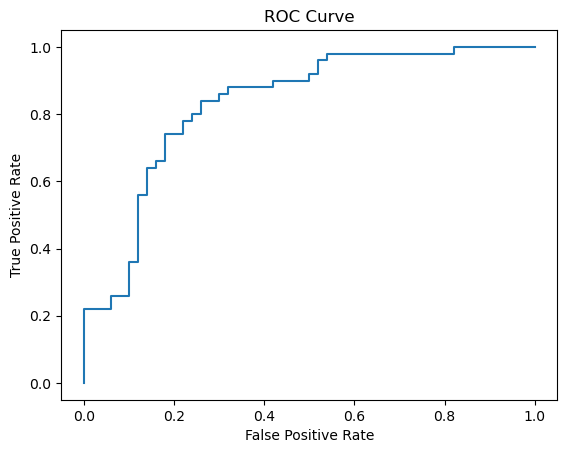

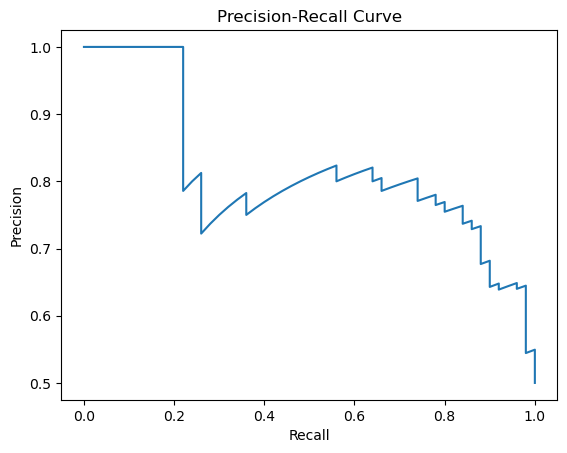

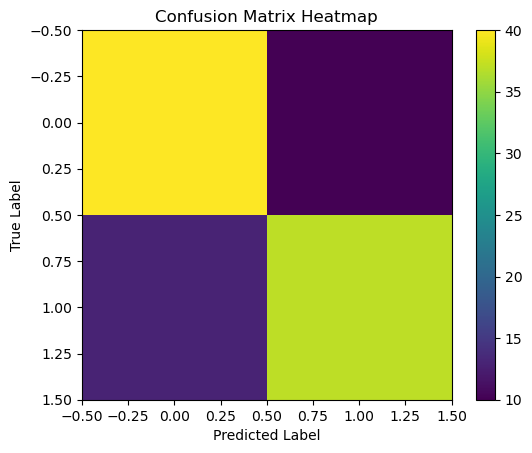

In [3]:
#!/usr/bin/env python3
import logging
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# --- Config ---------------------------------------------------------------
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

DATA_PATH = Path(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv")
TARGET_COL = "Group"
RANDOM_STATE = 42

# Features that will always be included
FIXED_FEATURES = [
    



    "Max_Dwell_Time_median",
  
    'Mean_Window_Entropy_median',
        
        "Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
   'Fixation_Deviation_Variance_kurtosis_func', 'Fixation_Deviation_Variance_std',
    "nu_mean",  "mt_std", "beta_std",'r_mean','iota_mean',
    "totaltime_exp", 'gazedur_exp',
   
    "Self_Transition_Ratio_Count_mean", "Entropy_Deviation_kurtosis_func", 'Regression_Transition_Ratio_Count_kurtosis_func'
]

# conceptual feature families
BASES = [
    "mean_saccade_amplitude",
    "std_saccade_velocity",
    "mean_fixation_duration",
]
SUFFIXES = ["std", "mean", "median", "skew", "kurtosis_func"]

# Grid search parameters for the classifier
GRID_PARAMS = {
    "clf__kernel": ["linear", "rbf"],
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
}


def make_pipeline():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("clf", SVC(
            probability=True,
            class_weight="balanced",
            random_state=RANDOM_STATE
        )),
    ])


def nested_cv_mean_auc(X, y):
    """
    Perform nested cross-validation and return mean ROC-AUC.
    """
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        make_pipeline(), GRID_PARAMS,
        scoring="roc_auc", cv=inner, n_jobs=-1, refit=True
    )
    scores = []
    for tr_idx, te_idx in outer.split(X, y):
        grid.fit(X[tr_idx], y[tr_idx])
        prob = grid.predict_proba(X[te_idx])[:, 1]
        scores.append(roc_auc_score(y[te_idx], prob))
    return np.mean(scores)


def main():
    # Load data and encode target
    df = pd.read_csv(DATA_PATH)
    le = LabelEncoder().fit(df[TARGET_COL])
    y = le.transform(df[TARGET_COL])

    # 1) Candidate features: all base-suffix combinations present in data
    all_variants = [f"{b}_{suf}" for b in BASES for suf in SUFFIXES if f"{b}_{suf}" in df.columns]
    log.info("Found %d base variants", len(all_variants))

    # 2) Group by family
    family_variants = {b: [v for v in all_variants if v.startswith(b + "_")] for b in BASES}
    families = [b for b, variants in family_variants.items() if variants]

    # 3) Initial picks: for each base, pick the '_std' variant if available, else first
    initial_picks = {
        b: (f"{b}_std" if f"{b}_std" in family_variants[b] else family_variants[b][0])
        for b in families
    }
    current_picks = initial_picks.copy()
    log.info("Initial variant picks per family: %s", current_picks)

    # 4) Wrapper-based selection: fix other bases + fixed features, iterate each family
    improved = True
    while improved:
        improved = False
        for base in families:
            # always include fixed features and current picks for other families
            other_feats = FIXED_FEATURES + [current_picks[b] for b in families if b != base]
            best_auc = nested_cv_mean_auc(df[other_feats + [current_picks[base]]].values, y)
            best_variant = current_picks[base]
            # try each candidate in this family
            for variant in family_variants[base]:
                trial_feats = other_feats + [variant]
                auc = nested_cv_mean_auc(df[trial_feats].values, y)
                if auc > best_auc + 1e-4:
                    best_auc = auc
                    best_variant = variant
            # update if improved
            if best_variant != current_picks[base]:
                log.info("Updating %s: %s -> %s (AUC: %.3f)", base, current_picks[base], best_variant, best_auc)
                current_picks[base] = best_variant
                improved = True

    # 5) Final feature list
    final_features = FIXED_FEATURES + list(current_picks.values())
    log.info("Final feature set: %s", final_features)

    # 6) Evaluate initial vs final
    init_feats = FIXED_FEATURES + list(initial_picks.values())
    auc_init = nested_cv_mean_auc(df[init_feats].values, y)
    auc_final = nested_cv_mean_auc(df[final_features].values, y)
    print(f"Nested CV AUC (initial features): {auc_init:.3f}")
    print(f"Nested CV AUC (final features):   {auc_final:.3f}")
    print(f"Δ AUC: {auc_final - auc_init:+.3f}\n")

    # 7) Final model training and evaluation
    clf = GridSearchCV(
        make_pipeline(), GRID_PARAMS,
        scoring="roc_auc",
        cv=StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE),
        n_jobs=-1
    )
    clf.fit(df[final_features].values, y)
    best_pipe = clf.best_estimator_
    print(f"Best hyperparameters: {clf.best_params_}")

    # Cross-validated predictions
    cv5 = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    y_pred = cross_val_predict(best_pipe, df[final_features].values, y, cv=cv5)
    y_score = cross_val_predict(best_pipe, df[final_features].values, y, cv=cv5, method="predict_proba")[:, 1]

    # Reports
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix:\n", cm)

    # Plots
    fpr, tpr, _ = roc_curve(y, y_score)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()

    precision, recall, _ = precision_recall_curve(y, y_score)
    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix Heatmap")
    plt.colorbar()
    plt.show()


if __name__ == "__main__":
    main()


2025-05-11 00:09:37,612 INFO Found 15 base variants
2025-05-11 00:09:37,613 INFO Initial variant picks per family: {'mean_saccade_amplitude': 'mean_saccade_amplitude_std', 'std_saccade_velocity': 'std_saccade_velocity_std', 'mean_fixation_duration': 'mean_fixation_duration_std'}
2025-05-11 00:10:21,188 INFO Updating mean_fixation_duration: mean_fixation_duration_std -> mean_fixation_duration_mean (AUC: 0.800)
2025-05-11 00:11:00,661 INFO Final feature set: ['Max_Dwell_Time_median', 'Mean_Window_Entropy_median', 'Frac_Extreme_X_std', 'State_Occupancy_Entropy_std', 'Fixation_Deviation_Variance_kurtosis_func', 'nu_mean', 'mt_sd', 'beta_sd', 'r_mean', 'iota_mean', 'totaltime_exp', 'gazedur_exp', 'Self_Transition_Ratio_Count_mean', 'Entropy_Deviation_kurtosis_func', 'Regression_Transition_Ratio_Count_kurtosis_func', 'mean_saccade_amplitude_std', 'std_saccade_velocity_std', 'mean_fixation_duration_mean']


Nested CV AUC (initial features): 0.780
Nested CV AUC (final features):   0.800
Δ AUC: +0.020

Best hyperparameters: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}

Classification Report:
              precision    recall  f1-score   support

        ADHD       0.75      0.72      0.73        50
          TD       0.73      0.76      0.75        50

    accuracy                           0.74       100
   macro avg       0.74      0.74      0.74       100
weighted avg       0.74      0.74      0.74       100

Confusion Matrix:
 [[36 14]
 [12 38]]


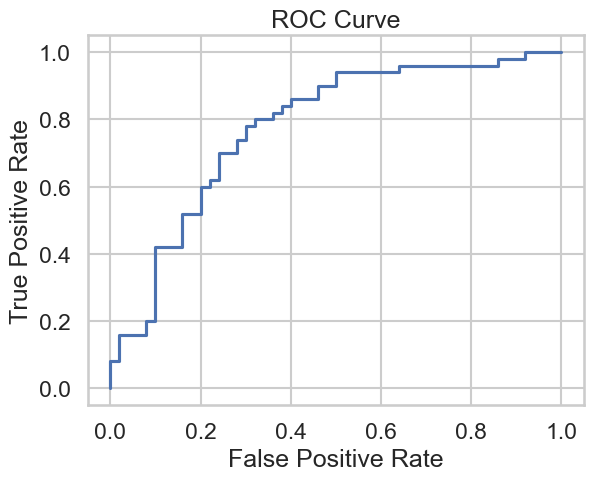

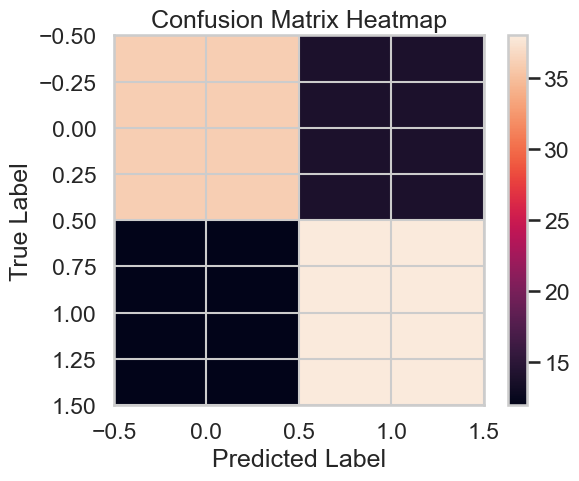

In [19]:
#!/usr/bin/env python3
import logging
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# --- Config ---------------------------------------------------------------
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

DATA_PATH = Path(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output1000.csv")
TARGET_COL = "Group"
RANDOM_STATE = 42

# Features that will always be included
FIXED_FEATURES = [
    



    "Max_Dwell_Time_median",
  
    'Mean_Window_Entropy_median',
        
        "Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
   'Fixation_Deviation_Variance_kurtosis_func',
    "nu_mean",  "mt_sd", "beta_sd",'r_mean','iota_mean',
    "totaltime_exp", 'gazedur_exp',
   
    "Self_Transition_Ratio_Count_mean", "Entropy_Deviation_kurtosis_func", 'Regression_Transition_Ratio_Count_kurtosis_func'
]

# conceptual feature families
BASES = [
    "mean_saccade_amplitude",
    "std_saccade_velocity",
    "mean_fixation_duration",
]
SUFFIXES = ["std", "mean", "median", "skew", "kurtosis_func"]

# Grid search parameters for the classifier
GRID_PARAMS = {
    "clf__kernel": ["linear", "rbf"],
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
}


def make_pipeline():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("clf", SVC(
            probability=True,
            class_weight="balanced",
            random_state=RANDOM_STATE
        )),
    ])


def nested_cv_mean_auc(X, y):
    """
    Perform nested cross-validation and return mean ROC-AUC.
    """
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        make_pipeline(), GRID_PARAMS,
        scoring="roc_auc", cv=inner, n_jobs=-1, refit=True
    )
    scores = []
    for tr_idx, te_idx in outer.split(X, y):
        grid.fit(X[tr_idx], y[tr_idx])
        prob = grid.predict_proba(X[te_idx])[:, 1]
        scores.append(roc_auc_score(y[te_idx], prob))
    return np.mean(scores)


def main():
    # Load data and encode target
    df = pd.read_csv(DATA_PATH)
    le = LabelEncoder().fit(df[TARGET_COL])
    y = le.transform(df[TARGET_COL])

    # 1) Candidate features: all base-suffix combinations present in data
    all_variants = [f"{b}_{suf}" for b in BASES for suf in SUFFIXES if f"{b}_{suf}" in df.columns]
    log.info("Found %d base variants", len(all_variants))

    # 2) Group by family
    family_variants = {b: [v for v in all_variants if v.startswith(b + "_")] for b in BASES}
    families = [b for b, variants in family_variants.items() if variants]

    # 3) Initial picks: for each base, pick the '_std' variant if available, else first
    initial_picks = {
        b: (f"{b}_std" if f"{b}_std" in family_variants[b] else family_variants[b][0])
        for b in families
    }
    current_picks = initial_picks.copy()
    log.info("Initial variant picks per family: %s", current_picks)

    # 4) Wrapper-based selection: fix other bases + fixed features, iterate each family
    improved = True
    while improved:
        improved = False
        for base in families:
            # always include fixed features and current picks for other families
            other_feats = FIXED_FEATURES + [current_picks[b] for b in families if b != base]
            best_auc = nested_cv_mean_auc(df[other_feats + [current_picks[base]]].values, y)
            best_variant = current_picks[base]
            # try each candidate in this family
            for variant in family_variants[base]:
                trial_feats = other_feats + [variant]
                auc = nested_cv_mean_auc(df[trial_feats].values, y)
                if auc > best_auc + 1e-4:
                    best_auc = auc
                    best_variant = variant
            # update if improved
            if best_variant != current_picks[base]:
                log.info("Updating %s: %s -> %s (AUC: %.3f)", base, current_picks[base], best_variant, best_auc)
                current_picks[base] = best_variant
                improved = True

    # 5) Final feature list
    final_features = FIXED_FEATURES + list(current_picks.values())
    log.info("Final feature set: %s", final_features)

    # 6) Evaluate initial vs final
    init_feats = FIXED_FEATURES + list(initial_picks.values())
    auc_init = nested_cv_mean_auc(df[init_feats].values, y)
    auc_final = nested_cv_mean_auc(df[final_features].values, y)
    print(f"Nested CV AUC (initial features): {auc_init:.3f}")
    print(f"Nested CV AUC (final features):   {auc_final:.3f}")
    print(f"Δ AUC: {auc_final - auc_init:+.3f}\n")

    # 7) Final model training and evaluation
    clf = GridSearchCV(
        make_pipeline(), GRID_PARAMS,
        scoring="roc_auc",
        cv=StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE),
        n_jobs=-1
    )
    clf.fit(df[final_features].values, y)
    best_pipe = clf.best_estimator_
    print(f"Best hyperparameters: {clf.best_params_}")

    # Cross-validated predictions
    cv5 = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    y_pred = cross_val_predict(best_pipe, df[final_features].values, y, cv=cv5)
    y_score = cross_val_predict(best_pipe, df[final_features].values, y, cv=cv5, method="predict_proba")[:, 1]

    # Reports
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix:\n", cm)

    # Plots
    fpr, tpr, _ = roc_curve(y, y_score)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()

    precision, recall, _ = precision_recall_curve(y, y_score)
    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix Heatmap")
    plt.colorbar()
    plt.show()


if __name__ == "__main__":
    main()


2025-05-10 17:53:10,176 INFO Fold 1: AUC = 0.800
2025-05-10 17:53:11,020 INFO Fold 2: AUC = 0.900
2025-05-10 17:53:11,739 INFO Fold 3: AUC = 0.850
2025-05-10 17:53:12,654 INFO Fold 4: AUC = 0.770
2025-05-10 17:53:13,798 INFO Fold 5: AUC = 0.940
2025-05-10 17:53:13,808 INFO Nested‑CV AUC: 0.852 (95% CI 0.773–0.936)
2025-05-10 17:53:14,742 INFO Final best params: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
2025-05-10 17:53:16,468 INFO Completed bootstrap fold 1
2025-05-10 17:53:18,178 INFO Completed bootstrap fold 2
2025-05-10 17:53:19,908 INFO Completed bootstrap fold 3
2025-05-10 17:53:21,637 INFO Completed bootstrap fold 4
2025-05-10 17:53:23,415 INFO Completed bootstrap fold 5
2025-05-10 17:53:25,219 INFO Fold 1 perm-importance values collected
2025-05-10 17:53:27,045 INFO Fold 2 perm-importance values collected
2025-05-10 17:53:28,852 INFO Fold 3 perm-importance values collected
2025-05-10 17:53:30,646 INFO Fold 4 perm-importance values collected
2025-05-10 17:53

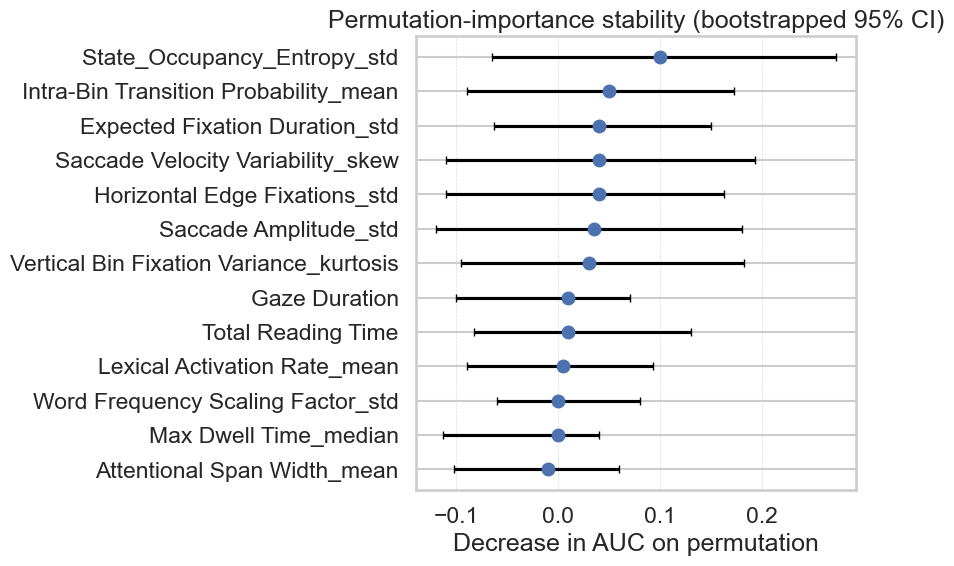

2025-05-10 17:53:36,539 INFO Figure saved: D:\ACIT Master's Thesis\New data\Figures\pdp_Total_Reading_Time.png & D:\ACIT Master's Thesis\New data\Figures\pdp_Total_Reading_Time.pdf


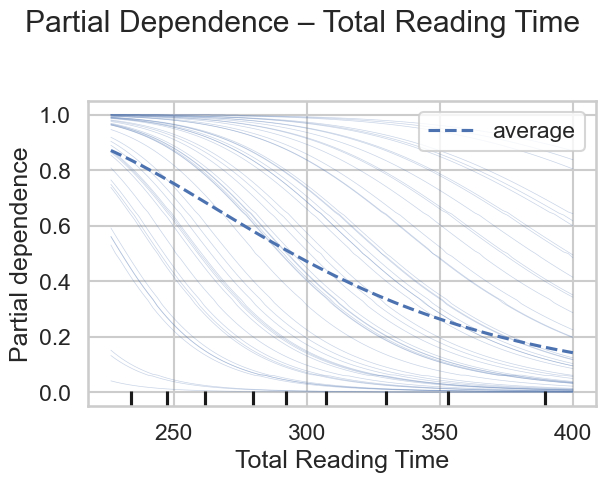

2025-05-10 17:53:39,059 INFO Figure saved: D:\ACIT Master's Thesis\New data\Figures\pdp_Gaze_Duration.png & D:\ACIT Master's Thesis\New data\Figures\pdp_Gaze_Duration.pdf


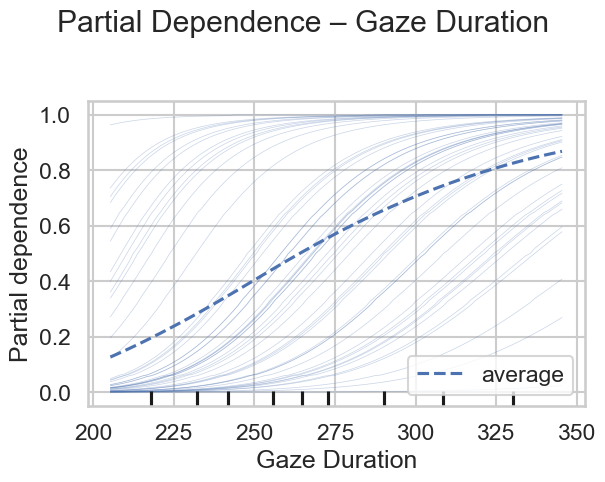

2025-05-10 17:53:41,494 INFO Figure saved: D:\ACIT Master's Thesis\New data\Figures\pdp_Saccade_Amplitude_std.png & D:\ACIT Master's Thesis\New data\Figures\pdp_Saccade_Amplitude_std.pdf


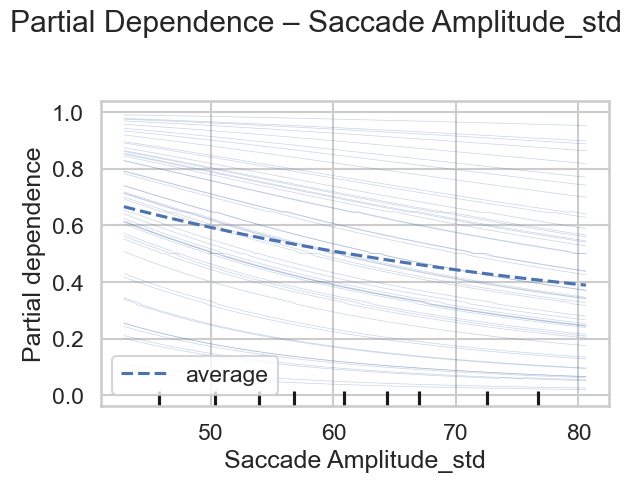

2025-05-10 17:53:42,067 INFO Computing SHAP importance...


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:53:42,091 INFO num_full_subsets = 1
2025-05-10 17:53:42,092 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:53:42,093 INFO num_paired_subset_sizes = 6
2025-05-10 17:53:42,101 INFO weight_left = 0.6508991990327944
2025-05-10 17:53:42,144 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 17:53:42,145 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 17:53:42,160 INFO phi = array([-0.1268936 ,  0.17786123, -0.03982746,  0.        ,  0.02845776,
       -0.03690133, -0.34378118,  0.1285869 ,  0.04981468,  0.02475329,
       -0.08008934,  0.        ,  0.        ])
2025-05-10 17:53:42,170 INFO num_full_subsets = 1
2025-05-10 17:53:42,172 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:53:42,173 INFO num_paired_subset_sizes = 6
2025-05-10 17:53:42,181 INFO weight_left = 0.6508991990327944
2025-05-10 17:53:42,226 INFO np.sum(w_aug) = 13.000000000000004


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:53:49,496 INFO num_full_subsets = 1
2025-05-10 17:53:49,498 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:53:49,498 INFO num_paired_subset_sizes = 6
2025-05-10 17:53:49,506 INFO weight_left = 0.6508991990327944
2025-05-10 17:53:49,560 INFO np.sum(w_aug) = 13.0
2025-05-10 17:53:49,561 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 17:53:49,565 INFO phi = array([ 0.        ,  0.        , -0.10074689,  0.09676457,  0.11660037,
       -0.04948087, -0.15428425,  0.03886796,  0.0417218 , -0.0346858 ,
        0.        ,  0.04533257, -0.03001855])
2025-05-10 17:53:49,573 INFO num_full_subsets = 1
2025-05-10 17:53:49,573 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:53:49,574 INFO num_paired_subset_sizes = 6
2025-05-10 17:53:49,581 INFO weight_left = 0.6508991990327944
2025-05-10 17:53:49,628 INFO np.sum(w_aug) = 13.0
2025-05-10 17:53:49,629 INFO

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:53:56,886 INFO num_full_subsets = 1
2025-05-10 17:53:56,887 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:53:56,888 INFO num_paired_subset_sizes = 6
2025-05-10 17:53:56,896 INFO weight_left = 0.6508991990327944
2025-05-10 17:53:56,950 INFO np.sum(w_aug) = 13.000000000000004
2025-05-10 17:53:56,951 INFO np.sum(self.kernelWeights) = 0.9999999999999999
2025-05-10 17:53:56,956 INFO phi = array([ 0.06823522,  0.03437529,  0.        ,  0.        , -0.04324199,
        0.        , -0.05345813,  0.16243158,  0.26533853, -0.16757862,
        0.05156617, -0.09747547,  0.0965199 ])
2025-05-10 17:53:56,963 INFO num_full_subsets = 1
2025-05-10 17:53:56,964 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:53:56,965 INFO num_paired_subset_sizes = 6
2025-05-10 17:53:56,974 INFO weight_left = 0.6508991990327944
2025-05-10 17:53:57,030 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:54:04,694 INFO num_full_subsets = 1
2025-05-10 17:54:04,696 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:04,696 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:04,706 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:04,753 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 17:54:04,753 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 17:54:04,772 INFO phi = array([-0.04141468, -0.11024473,  0.        , -0.04926527, -0.1015471 ,
        0.06723723, -0.15049739,  0.26322928,  0.1543733 ,  0.        ,
        0.        , -0.12731185,  0.13882063])
2025-05-10 17:54:04,780 INFO num_full_subsets = 1
2025-05-10 17:54:04,780 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:04,780 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:04,791 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:04,834 INFO np.sum(w_aug) = 13.000000000000002


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:54:12,459 INFO num_full_subsets = 1
2025-05-10 17:54:12,459 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:12,460 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:12,468 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:12,517 INFO np.sum(w_aug) = 13.0
2025-05-10 17:54:12,518 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 17:54:12,522 INFO phi = array([-0.02174538,  0.11163845, -0.08144771, -0.00942438, -0.03041996,
        0.        ,  0.08521276, -0.03608014,  0.14616396,  0.        ,
        0.        ,  0.04777866,  0.02207053])
2025-05-10 17:54:12,527 INFO num_full_subsets = 1
2025-05-10 17:54:12,527 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:12,530 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:12,538 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:12,583 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 17:

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:54:19,927 INFO num_full_subsets = 1
2025-05-10 17:54:19,929 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:19,930 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:19,936 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:19,985 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 17:54:19,986 INFO np.sum(self.kernelWeights) = 1.0000000000000002
2025-05-10 17:54:19,991 INFO phi = array([ 0.10033458,  0.02884574, -0.07603645, -0.04562339,  0.        ,
        0.20669526, -0.37641395,  0.14777791,  0.        ,  0.22663652,
       -0.04697513,  0.        , -0.032221  ])
2025-05-10 17:54:19,997 INFO num_full_subsets = 1
2025-05-10 17:54:19,998 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:19,999 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:20,006 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:20,053 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:54:27,278 INFO num_full_subsets = 1
2025-05-10 17:54:27,279 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:27,280 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:27,289 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:27,338 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 17:54:27,338 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 17:54:27,345 INFO phi = array([ 0.17346064, -0.02051842,  0.02968799,  0.        ,  0.        ,
        0.        , -0.15017754,  0.21910025,  0.31819706, -0.22307863,
        0.02089757, -0.11187037,  0.0558045 ])
2025-05-10 17:54:27,351 INFO num_full_subsets = 1
2025-05-10 17:54:27,354 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:27,355 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:27,363 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:27,411 INFO np.sum(w_aug) = 13.000000000000002


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:54:34,692 INFO num_full_subsets = 1
2025-05-10 17:54:34,693 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:34,694 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:34,703 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:34,759 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 17:54:34,760 INFO np.sum(self.kernelWeights) = 0.9999999999999999
2025-05-10 17:54:34,765 INFO phi = array([-0.17870481, -0.02054133,  0.        ,  0.10065102, -0.06152432,
        0.        ,  0.15483491, -0.09879275, -0.23044059,  0.12833385,
        0.05820379,  0.        , -0.02808004])
2025-05-10 17:54:34,772 INFO num_full_subsets = 1
2025-05-10 17:54:34,774 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:34,774 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:34,780 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:34,826 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:54:42,102 INFO num_full_subsets = 1
2025-05-10 17:54:42,103 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:42,103 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:42,112 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:42,168 INFO np.sum(w_aug) = 13.000000000000004
2025-05-10 17:54:42,170 INFO np.sum(self.kernelWeights) = 0.9999999999999999
2025-05-10 17:54:42,175 INFO phi = array([-0.02019886,  0.10211117,  0.        ,  0.03231256,  0.06563837,
       -0.11408213,  0.        , -0.0659121 , -0.05852364,  0.17212744,
        0.07903038,  0.04303669,  0.        ])
2025-05-10 17:54:42,183 INFO num_full_subsets = 1
2025-05-10 17:54:42,184 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:42,184 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:42,192 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:42,245 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:54:49,534 INFO num_full_subsets = 1
2025-05-10 17:54:49,535 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:49,536 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:49,543 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:49,583 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 17:54:49,584 INFO np.sum(self.kernelWeights) = 1.0000000000000002
2025-05-10 17:54:49,591 INFO phi = array([-0.07866046,  0.        ,  0.        , -0.07653564,  0.        ,
        0.09099736, -0.14243365,  0.23160592,  0.26126403, -0.29742046,
        0.06507337,  0.05289151,  0.03142802])
2025-05-10 17:54:49,596 INFO num_full_subsets = 1
2025-05-10 17:54:49,597 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:49,598 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:49,606 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:49,653 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:54:56,967 INFO num_full_subsets = 1
2025-05-10 17:54:56,968 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:56,968 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:56,973 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:57,029 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 17:54:57,030 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 17:54:57,035 INFO phi = array([-0.05314169,  0.        , -0.11443176, -0.08450342,  0.        ,
       -0.03312146,  0.04148687,  0.07221805,  0.30507113, -0.3240523 ,
        0.0789248 ,  0.05600246,  0.        ])
2025-05-10 17:54:57,042 INFO num_full_subsets = 1
2025-05-10 17:54:57,044 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:54:57,044 INFO num_paired_subset_sizes = 6
2025-05-10 17:54:57,052 INFO weight_left = 0.6508991990327944
2025-05-10 17:54:57,101 INFO np.sum(w_aug) = 13.0
2025-05-10 17:

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:55:04,523 INFO num_full_subsets = 1
2025-05-10 17:55:04,524 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:04,524 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:04,534 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:04,587 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 17:55:04,588 INFO np.sum(self.kernelWeights) = 1.0000000000000002
2025-05-10 17:55:04,594 INFO phi = array([-0.06720231,  0.13026481,  0.09012437, -0.05982107,  0.        ,
        0.1248155 ,  0.13847012, -0.0766945 , -0.12485871,  0.18149846,
        0.        ,  0.03061635,  0.        ])
2025-05-10 17:55:04,602 INFO num_full_subsets = 1
2025-05-10 17:55:04,604 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:04,605 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:04,612 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:04,667 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:55:12,049 INFO num_full_subsets = 1
2025-05-10 17:55:12,050 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:12,051 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:12,060 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:12,114 INFO np.sum(w_aug) = 13.0
2025-05-10 17:55:12,115 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 17:55:12,120 INFO phi = array([ 0.15359017, -0.07809755,  0.06564467,  0.        , -0.0720962 ,
        0.20064387,  0.08857499,  0.        , -0.12310281,  0.16078466,
        0.        ,  0.03657023, -0.03986793])
2025-05-10 17:55:12,125 INFO num_full_subsets = 1
2025-05-10 17:55:12,126 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:12,127 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:12,135 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:12,184 INFO np.sum(w_aug) = 13.000000000000004
2025-05-10 17:

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:55:19,466 INFO num_full_subsets = 1
2025-05-10 17:55:19,467 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:19,468 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:19,474 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:19,520 INFO np.sum(w_aug) = 13.0
2025-05-10 17:55:19,521 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 17:55:19,526 INFO phi = array([ 0.03000669, -0.13709406,  0.        ,  0.02140241,  0.07129911,
       -0.03297584,  0.21175994, -0.25368137, -0.35004624,  0.15282812,
       -0.02654656,  0.        ,  0.        ])
2025-05-10 17:55:19,534 INFO num_full_subsets = 1
2025-05-10 17:55:19,535 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:19,536 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:19,543 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:19,598 INFO np.sum(w_aug) = 13.000000000000004
2025-05-10 17:

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:55:26,961 INFO num_full_subsets = 1
2025-05-10 17:55:26,962 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:26,963 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:26,971 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:27,027 INFO np.sum(w_aug) = 13.0
2025-05-10 17:55:27,028 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 17:55:27,034 INFO phi = array([ 0.        ,  0.        , -0.08197492,  0.        ,  0.06798304,
        0.02635475, -0.38145821, -0.0554989 , -0.15936371,  0.24189025,
        0.02430416,  0.03994529, -0.10494539])
2025-05-10 17:55:27,041 INFO num_full_subsets = 1
2025-05-10 17:55:27,042 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:27,042 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:27,048 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:27,093 INFO np.sum(w_aug) = 13.0
2025-05-10 17:55:27,095 INFO

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:55:34,596 INFO num_full_subsets = 1
2025-05-10 17:55:34,597 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:34,597 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:34,604 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:34,654 INFO np.sum(w_aug) = 13.0
2025-05-10 17:55:34,655 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 17:55:34,659 INFO phi = array([-0.0684985 ,  0.        , -0.08932977, -0.0914695 ,  0.        ,
        0.        ,  0.03021762,  0.05920415,  0.32271792, -0.36135002,
        0.05584509,  0.03997536,  0.04714035])
2025-05-10 17:55:34,666 INFO num_full_subsets = 1
2025-05-10 17:55:34,669 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:34,670 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:34,677 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:34,735 INFO np.sum(w_aug) = 13.0
2025-05-10 17:55:34,736 INFO

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:55:42,106 INFO num_full_subsets = 1
2025-05-10 17:55:42,107 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:42,107 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:42,116 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:42,172 INFO np.sum(w_aug) = 13.0
2025-05-10 17:55:42,172 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 17:55:42,177 INFO phi = array([ 0.07398541, -0.08189814, -0.04702367,  0.        , -0.00998451,
       -0.03245546,  0.09598614,  0.        ,  0.18372013, -0.04392016,
        0.        , -0.11563762,  0.11023926])
2025-05-10 17:55:42,184 INFO num_full_subsets = 1
2025-05-10 17:55:42,185 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:42,186 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:42,195 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:42,237 INFO np.sum(w_aug) = 13.0
2025-05-10 17:55:42,238 INFO

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:55:49,497 INFO num_full_subsets = 1
2025-05-10 17:55:49,498 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:49,498 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:49,506 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:49,552 INFO np.sum(w_aug) = 13.000000000000004
2025-05-10 17:55:49,553 INFO np.sum(self.kernelWeights) = 1.0000000000000002
2025-05-10 17:55:49,560 INFO phi = array([ 0.10984742, -0.03148355,  0.        ,  0.0978763 ,  0.        ,
       -0.17616209,  0.24808245, -0.10998577,  0.37171764, -0.18895999,
        0.        , -0.09054567,  0.07897742])
2025-05-10 17:55:49,568 INFO num_full_subsets = 1
2025-05-10 17:55:49,569 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:49,570 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:49,577 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:49,627 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:55:56,861 INFO num_full_subsets = 1
2025-05-10 17:55:56,862 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:56,862 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:56,870 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:56,926 INFO np.sum(w_aug) = 13.000000000000004
2025-05-10 17:55:56,928 INFO np.sum(self.kernelWeights) = 0.9999999999999999
2025-05-10 17:55:56,932 INFO phi = array([ 0.15597609, -0.17830848,  0.        ,  0.        ,  0.15198871,
       -0.18370193,  0.04485227, -0.25107331,  0.        , -0.14576022,
        0.11225888,  0.04786979, -0.05064087])
2025-05-10 17:55:56,943 INFO num_full_subsets = 1
2025-05-10 17:55:56,944 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:55:56,945 INFO num_paired_subset_sizes = 6
2025-05-10 17:55:56,951 INFO weight_left = 0.6508991990327944
2025-05-10 17:55:57,006 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:56:04,230 INFO num_full_subsets = 1
2025-05-10 17:56:04,232 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:56:04,232 INFO num_paired_subset_sizes = 6
2025-05-10 17:56:04,238 INFO weight_left = 0.6508991990327944
2025-05-10 17:56:04,286 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 17:56:04,287 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 17:56:04,291 INFO phi = array([ 0.        ,  0.        , -0.04584223,  0.06303605,  0.04480312,
       -0.1022773 ,  0.0735549 , -0.23148079, -0.35930681,  0.32490686,
        0.        ,  0.16346264, -0.10692712])
2025-05-10 17:56:04,299 INFO num_full_subsets = 1
2025-05-10 17:56:04,300 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:56:04,301 INFO num_paired_subset_sizes = 6
2025-05-10 17:56:04,307 INFO weight_left = 0.6508991990327944
2025-05-10 17:56:04,358 INFO np.sum(w_aug) = 13.000000000000002


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:56:11,664 INFO num_full_subsets = 1
2025-05-10 17:56:11,665 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:56:11,666 INFO num_paired_subset_sizes = 6
2025-05-10 17:56:11,674 INFO weight_left = 0.6508991990327944
2025-05-10 17:56:11,720 INFO np.sum(w_aug) = 13.0
2025-05-10 17:56:11,720 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 17:56:11,727 INFO phi = array([ 0.15095011,  0.        ,  0.        ,  0.        , -0.10251888,
       -0.10447849,  0.09832118,  0.06332068,  0.23585846, -0.26967764,
       -0.06598238, -0.10013859,  0.04674037])
2025-05-10 17:56:11,733 INFO num_full_subsets = 1
2025-05-10 17:56:11,735 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:56:11,735 INFO num_paired_subset_sizes = 6
2025-05-10 17:56:11,743 INFO weight_left = 0.6508991990327944
2025-05-10 17:56:11,791 INFO np.sum(w_aug) = 13.000000000000004
2025-05-10 17:

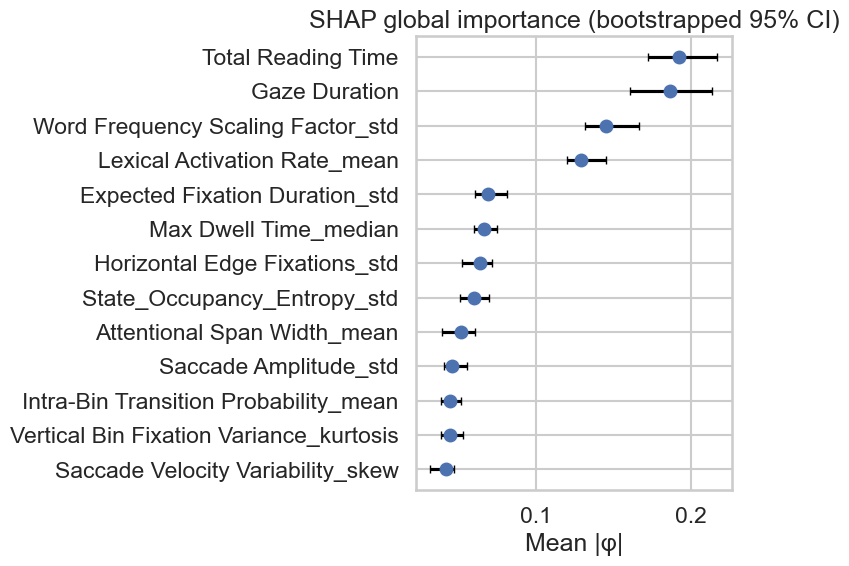

2025-05-10 17:56:25,067 INFO Figure saved: D:\ACIT Master's Thesis\New data\Figures\shap_summary_violin.png & D:\ACIT Master's Thesis\New data\Figures\shap_summary_violin.pdf


2025-05-10 17:56:27,952 INFO Figure saved: D:\ACIT Master's Thesis\New data\Figures\shap_summary_beeswarm.png & D:\ACIT Master's Thesis\New data\Figures\shap_summary_beeswarm.pdf


2025-05-10 17:56:28,334 INFO Computing SHAP interactions...


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 17:56:28,351 INFO num_full_subsets = 1
2025-05-10 17:56:28,352 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:56:28,352 INFO num_paired_subset_sizes = 6
2025-05-10 17:56:28,359 INFO weight_left = 0.6508991990327944
2025-05-10 17:56:28,395 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 17:56:28,395 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 17:56:28,399 INFO phi = array([-0.11118782,  0.17814205, -0.04516822, -0.0253232 ,  0.        ,
       -0.03563826, -0.34031069,  0.14042811,  0.06758613,  0.        ,
       -0.08662012,  0.04007296,  0.        ])
2025-05-10 17:56:28,406 INFO num_full_subsets = 1
2025-05-10 17:56:28,408 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:56:28,408 INFO num_paired_subset_sizes = 6
2025-05-10 17:56:28,415 INFO weight_left = 0.6508991990327944
2025-05-10 17:56:28,456 INFO np.sum(w_aug) = 13.000000000000002


  0%|          | 0/3 [00:00<?, ?it/s]

2025-05-10 17:56:38,099 INFO num_full_subsets = 1
2025-05-10 17:56:38,100 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:56:38,101 INFO num_paired_subset_sizes = 6
2025-05-10 17:56:38,106 INFO weight_left = 0.6508991990327944
2025-05-10 17:56:38,168 INFO np.sum(w_aug) = 13.000000000000004
2025-05-10 17:56:38,172 INFO np.sum(self.kernelWeights) = 1.0000000000000004
2025-05-10 17:56:38,175 INFO phi = array([ 0.        , -0.08387632, -0.07506747, -0.02637639, -0.05169464,
        0.        ,  0.16752897, -0.06381474, -0.04166388, -0.15772427,
       -0.07345896, -0.09348994,  0.        ])
2025-05-10 17:56:38,182 INFO num_full_subsets = 1
2025-05-10 17:56:38,183 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 17:56:38,184 INFO num_paired_subset_sizes = 6
2025-05-10 17:56:38,192 INFO weight_left = 0.6508991990327944
2025-05-10 17:56:38,284 INFO np.sum(w_aug) = 13.0

2025-05-10 17:56:41,636 INFO Figure saved: D:\ACIT Master's Thesis\New data\Figures\decision_case_38.png & D:\ACIT Master's Thesis\New data\Figures\decision_case_38.pdf


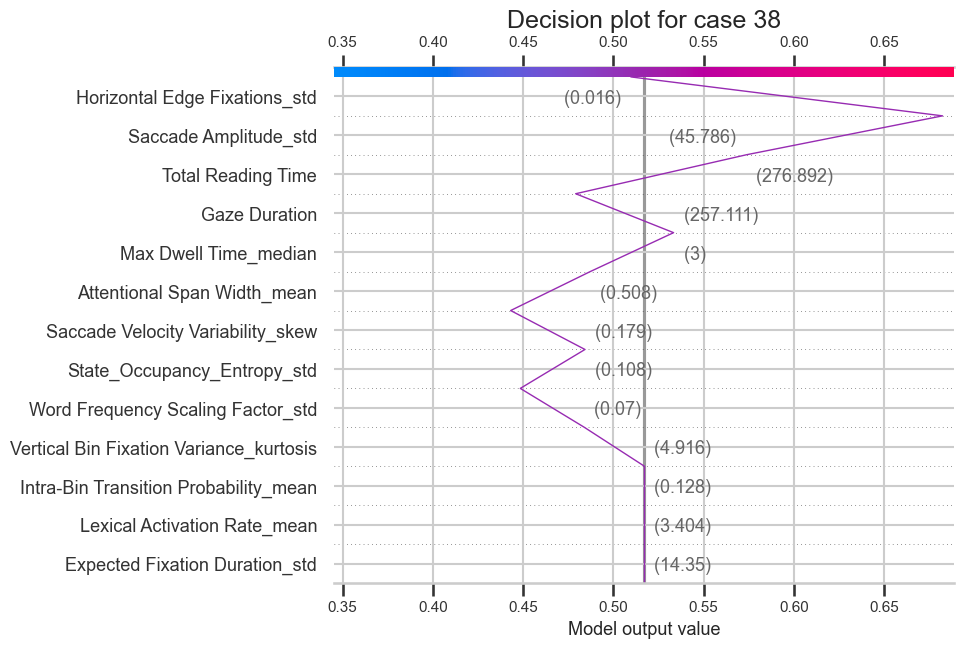

2025-05-10 17:56:43,410 INFO Figure saved: D:\ACIT Master's Thesis\New data\Figures\decision_case_74.png & D:\ACIT Master's Thesis\New data\Figures\decision_case_74.pdf


2025-05-10 17:56:43,813 INFO Model & threshold saved to svm_pipeline_full_accuracy_tuned.pkl


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Extended SVM analysis with nested cross‑validation, permutation importance,
partial‑dependence plots, SHAP explanations (global, directional, stability),
feature interactions, and local decision‑plot sanity checks.
High‑quality PNG + PDF outputs saved at 300 dpi.
"""
from __future__ import annotations

import argparse
import logging
import warnings
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

# ----------------------------------------------------------------------------
# CONFIG & LOGGING
# ----------------------------------------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

DATA_PATH = Path(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv")
FIG_DIR   = Path(r"D:/ACIT Master's Thesis/New data/Figures")

FIG_DIR.mkdir(parents=True, exist_ok=True)
DEFAULT_DPI = 300

FEATURES: list[str] = [
    "Horizontal Edge Fixations_std", "State_Occupancy_Entropy_std",
    "Vertical Bin Fixation Variance_kurtosis", "Saccade Amplitude_std",
    "Attentional Span Width_mean", "Expected Fixation Duration_std",
    "Word Frequency Scaling Factor_std", "Lexical Activation Rate_mean",
    "Total Reading Time", "Gaze Duration", "Saccade Velocity Variability_skew",
    "Max Dwell Time_median", "Intra-Bin Transition Probability_mean",
]
GROUPS = {
    # (unchanged)
}
TARGET = "Group"
RANDOM_STATE = 42
OUT_MODEL = "svm_pipeline_full_accuracy_tuned.pkl"

sns.set_theme(style="whitegrid", context="talk")

# ----------------------------------------------------------------------------
# UTILITIES
# ----------------------------------------------------------------------------
def save_fig(fig: plt.Figure, name: str, dpi: int = DEFAULT_DPI) -> None:
    """
    Save *fig* under FIG_DIR as PNG + PDF.
    """
    png_path = FIG_DIR / f"{name}.png"
    pdf_path = FIG_DIR / f"{name}.pdf"
    fig.savefig(png_path, dpi=dpi, bbox_inches="tight")
    fig.savefig(pdf_path, bbox_inches="tight")
    log.info("Figure saved: %s & %s", png_path, pdf_path)

# ----------------------------------------------------------------------------
# PIPELINE & NESTED‑CV
# ----------------------------------------------------------------------------
def build_pipeline(with_smote: bool = True) -> Pipeline:
    steps: list[tuple[str, object]] = [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
    ]
    if with_smote:
        steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
    steps.append(("clf", SVC(probability=True,
                              class_weight="balanced",
                              random_state=RANDOM_STATE)))
    return Pipeline(steps)


def nested_cv_evaluate(X: np.ndarray, y: np.ndarray):
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)

    param_grid = {
        "clf__kernel": ["linear", "rbf"],
        "clf__C": [0.1, 1, 10, 100],
        "clf__gamma": ["scale", "auto"],
    }

    grid = GridSearchCV(build_pipeline(), param_grid,
                        scoring="roc_auc", cv=inner,
                        n_jobs=-1, refit=True)
    aucs = []
    all_probs = np.zeros(len(y))
    for fold, (tr, te) in enumerate(outer.split(X, y), start=1):
        grid.fit(X[tr], y[tr])
        probs = grid.predict_proba(X[te])[:, 1]
        all_probs[te] = probs
        fpr, tpr, _ = roc_curve(y[te], probs)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
        log.info("Fold %d: AUC = %.3f", fold, fold_auc)

    mean_auc, lo, hi = np.mean(aucs), *np.percentile(aucs, [2.5, 97.5])
    log.info("Nested‑CV AUC: %.3f (95%% CI %.3f–%.3f)", mean_auc, lo, hi)

    grid.fit(X, y)
    log.info("Final best params: %s", grid.best_params_)
    return grid.best_estimator_, 0.5

# ----------------------------------------------------------------------------
# PERMUTATION IMPORTANCE (quick) & STABILITY
# ----------------------------------------------------------------------------
def compute_permutation_importance(X: np.ndarray, y: np.ndarray, n_repeats: int = 5):
    """
    Quick bootstrap permutation importance.
    """
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    rng = np.random.RandomState(RANDOM_STATE)

    for fold, (tr, te) in enumerate(outer.split(X, y), start=1):
        seeds = rng.randint(0, 2**31 - 1, size=n_repeats)
        def one_boot(seed):
            rs = np.random.RandomState(seed)
            idx = rs.randint(0, len(y[tr]), len(y[tr]))
            pipe = build_pipeline()
            pipe.fit(X[tr][idx], y[tr][idx])
            imp = permutation_importance(pipe, X[te], y[te],
                                         n_repeats=n_repeats,
                                         random_state=rs,
                                         scoring="roc_auc")
            return imp.importances_mean

        arr = np.vstack([one_boot(s) for s in seeds])
        df = pd.DataFrame(arr, columns=FEATURES)
        df.to_csv(FIG_DIR/f"perm_importance_bootstrap_fold{fold}.csv", index=False)
        log.info("Completed bootstrap fold %d", fold)


def compute_permutation_importance_stability(
    X: np.ndarray, y: np.ndarray, n_repeats: int = 30
):
    """
    Plot & save permutation-importance stability across folds using bootstrap CIs.
    """
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    all_importances = []

    # collect importances for each fold
    for fold, (tr, te) in enumerate(outer.split(X, y), start=1):
        pipe = build_pipeline()
        pipe.fit(X[tr], y[tr])
        imp = permutation_importance(
            pipe, X[te], y[te],
            n_repeats=n_repeats, random_state=RANDOM_STATE,
            scoring="roc_auc"
        )
        # transpose so each row is one bootstrap sample's importances
        all_importances.append(imp.importances.T)
        log.info("Fold %d perm-importance values collected", fold)

    # concatenate bootstrap samples: shape (folds*n_repeats, n_features)
    arr = np.vstack(all_importances)
    lower = np.percentile(arr, 2.5, axis=0)
    median = np.percentile(arr, 50, axis=0)
    upper = np.percentile(arr, 97.5, axis=0)
    order = np.argsort(median)[::-1]

    # plot median with CIs
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.errorbar(
        median[order], [FEATURES[i] for i in order],
        xerr=[median[order] - lower[order], upper[order] - median[order]],
        fmt='o', color='#4c72b0', ecolor='black', capsize=3
    )
    ax.invert_yaxis()
    ax.set_title("Permutation-importance stability (bootstrapped 95% CI)")
    ax.set_xlabel("Decrease in AUC on permutation")
    ax.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    save_fig(fig, "perm_importance_stability")
    plt.show()

# ----------------------------------------------------------------------------
# PARTIAL DEPENDENCE PLOTS
# ----------------------------------------------------------------------------
def plot_partial_dependence(
    estimator: Pipeline, df_X: pd.DataFrame, features: list[str]
):
    """
    Generate PDPs for each feature (ICE + PDP).
    """
    for feat in features:
        disp = PartialDependenceDisplay.from_estimator(
            estimator, df_X, [feat], kind="both",
            subsample=50, random_state=RANDOM_STATE,
            grid_resolution=100,
        )
        disp.figure_.suptitle(f"Partial Dependence – {feat}", y=1.02)
        plt.tight_layout()
        save_fig(disp.figure_, f"pdp_{feat.replace(' ', '_')}" )
        plt.show()

# ----------------------------------------------------------------------------
# SHAP EXPLANATIONS: GLOBAL, DIRECTIONAL, STABILITY
# ----------------------------------------------------------------------------
def compute_shap_importance(pipeline: Pipeline, X: np.ndarray,
                            filename: str = "shap_summary",
                            bootstrap: bool = True, n_boot: int = 20):
    """
    SHAP summary: bar (mean|φ|) with bootstrap percentile CIs, beeswarm & violin.
    """
    # background for explainer
    bg = shap.sample(X, min(50, len(X)), random_state=RANDOM_STATE)
    explainer = shap.KernelExplainer(
        lambda d: pipeline.predict_proba(d)[:, 1], bg
    )
    shap_vals_all = explainer.shap_values(X, nsamples=200)
    vals = shap_vals_all[1] if isinstance(shap_vals_all, list) else shap_vals_all

    # compute bootstrap CIs if requested
    if bootstrap:
        rng = np.random.RandomState(RANDOM_STATE)
        boot_means = []
        for _ in range(n_boot):
            idx = rng.choice(len(X), len(X), replace=True)
            vals_b = explainer.shap_values(X[idx], nsamples=200)
            v = vals_b[1] if isinstance(vals_b, list) else vals_b
            boot_means.append(np.abs(v).mean(0))
        arr = np.vstack(boot_means)
        lower = np.percentile(arr, 2.5, axis=0)
        median = np.percentile(arr, 50, axis=0)
        upper = np.percentile(arr, 97.5, axis=0)
        df_ci = pd.DataFrame({
            'Feature': FEATURES,
            'CI_lower': lower,
            'Median': median,
            'CI_upper': upper
        }).sort_values('Median', ascending=False)
        df_ci.to_csv(FIG_DIR/f"{filename}_bootstrap_CI.csv", index=False)
        log.info("Saved SHAP bootstrap CI stats")
    else:
        # median equals mean if no bootstrap
        median = np.abs(vals).mean(0)
        df_ci = pd.DataFrame({
            'Feature': FEATURES,
            'CI_lower': median,
            'Median': median,
            'CI_upper': median
        }).sort_values('Median', ascending=False)

    # save overall mean|φ|
    df_global = pd.DataFrame({"Feature": FEATURES,
                              "Mean|φ|": np.abs(vals).mean(0)})
    df_global = df_global.sort_values("Mean|φ|", ascending=False)
    df_global.to_csv(FIG_DIR/f"{filename}_global.csv", index=False)

    # plot global importance with bootstrap CIs
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.errorbar(
        df_ci['Median'], df_ci['Feature'],
        xerr=[df_ci['Median'] - df_ci['CI_lower'], df_ci['CI_upper'] - df_ci['Median']],
        fmt='o', color='#4c72b0', ecolor='black', capsize=3
    )
    ax.invert_yaxis()
    ax.set_title("SHAP global importance (bootstrapped 95% CI)")
    ax.set_xlabel("Mean |φ|")
    plt.tight_layout(); save_fig(fig, f"{filename}_bar"); plt.show()

    # Directionality: violin & beeswarm
    fig = shap.summary_plot(vals, X, feature_names=FEATURES,
                            plot_type="violin", show=False)
    plt.title("SHAP directional (layered violin)")
    save_fig(plt.gcf(), f"{filename}_violin"); plt.show()
    shap.summary_plot(vals, X, feature_names=FEATURES,
                      plot_type="dot", show=False)
    save_fig(plt.gcf(), f"{filename}_beeswarm"); plt.show()

# ----------------------------------------------------------------------------
# SHAP INTERACTIONS (TOP‑K HEATMAP)
# ----------------------------------------------------------------------------
def compute_shap_interactions(
    pipeline: Pipeline, X: np.ndarray, max_display: int = 10
):
    bg = shap.sample(X, min(50, len(X)), random_state=RANDOM_STATE)
    explainer = shap.KernelExplainer(
        lambda d: pipeline.predict_proba(d)[:, 1], bg
    )
    shap_vals = explainer.shap_values(X, nsamples=200)
    vals = shap_vals[1] if isinstance(shap_vals, list) else shap_vals
    p = vals.shape[1]
    inter = np.zeros((p, p))
    for i in range(p):
        for j in range(i+1, p):
            inter[i, j] = inter[j, i] = np.abs(vals[:, i] * vals[:, j]).mean()
    pairs = [((i, j), inter[i, j]) for i in range(p) for j in range(i+1, p)]
    top = sorted(pairs, key=lambda x: x[1], reverse=True)[:max_display]
    H = np.zeros_like(inter)
    for (i, j), v in top:
        H[i, j] = H[j, i] = v
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(H, xticklabels=FEATURES, yticklabels=FEATURES,
                square=True, cbar_kws={"label": "mean|φᵢ·φⱼ|"}, ax=ax)
    ax.set_title(f"Top-{max_display} SHAP interactions")
    plt.tight_layout(); save_fig(fig, "shap_interactions"); plt.show()

# ----------------------------------------------------------------------------
# LOCAL SANITY CHECKS (DECISION PLOTS)
# ----------------------------------------------------------------------------
def local_sanity_checks(
    pipeline: Pipeline, X: np.ndarray, y: np.ndarray,
    threshold: float = 0.5, n_cases: int = 3
):
    """
    Generate decision plots for cases near the classification threshold.
    """
    probs = pipeline.predict_proba(X)[:, 1]
    # get indexes just below, near, and above threshold
    diffs = probs - threshold
    idx_below = np.argsort(diffs)[0]
    idx_near = np.argsort(np.abs(diffs))[0]
    idx_above = np.argsort(diffs)[-1]
    idxs = [idx_below, idx_near, idx_above][:n_cases]

    # background for explainer
    bg = shap.sample(X, min(200, len(X)), random_state=RANDOM_STATE)
    explainer = shap.KernelExplainer(
        lambda d: pipeline.predict_proba(d)[:, 1], bg
    )

    shap_vals_all = explainer.shap_values(X[idxs], nsamples=200)
    if isinstance(shap_vals_all, list):
        shap_vals = shap_vals_all[1]
        expected = explainer.expected_value[1]
    else:
        shap_vals = shap_vals_all
        expected = explainer.expected_value

    for k, sv in zip(idxs, shap_vals):
        shap.decision_plot(
            expected, sv, X[k],
            feature_names=FEATURES,
            show=False
        )
        fig = plt.gcf()
        plt.title(f"Decision plot for case {k}")
        save_fig(fig, f"decision_case_{k}")
        plt.show()

# ----------------------------------------------------------------------------
def main() -> None:
    parser = argparse.ArgumentParser(
        description="Extended SVM analysis with nested CV, permutation, PDP, SHAP"
    )
    parser.add_argument("--data-path", type=Path, default=DATA_PATH)
    args, _ = parser.parse_known_args()

    df = pd.read_csv(args.data_path)
    X = df[FEATURES].values
    y = LabelEncoder().fit_transform(df[TARGET])

    pipe, thr = nested_cv_evaluate(X, y)

    # Permutation importance
    compute_permutation_importance(X, y)
    compute_permutation_importance_stability(X, y)

    # PDPs
    PDP_FEATURES = ["Total Reading Time", "Gaze Duration", "Saccade Amplitude_std"]
    plot_partial_dependence(pipe, df[FEATURES], PDP_FEATURES)

    # SHAP explanations
    log.info("Computing SHAP importance...")
    compute_shap_importance(pipe, X)
    log.info("Computing SHAP interactions...")
    compute_shap_interactions(pipe, X)

    # Local sanity
    local_sanity_checks(pipe, X, y, threshold=thr, n_cases=3)

    joblib.dump({"pipeline": pipe, "threshold": thr}, OUT_MODEL)
    log.info("Model & threshold saved to %s", OUT_MODEL)

if __name__ == "__main__":
    main()


2025-05-10 18:10:08,884 INFO Fold 1: AUC = 0.800
2025-05-10 18:10:09,596 INFO Fold 2: AUC = 0.900
2025-05-10 18:10:10,304 INFO Fold 3: AUC = 0.850
2025-05-10 18:10:11,208 INFO Fold 4: AUC = 0.770
2025-05-10 18:10:12,374 INFO Fold 5: AUC = 0.940
2025-05-10 18:10:12,375 INFO Nested‑CV AUC: 0.852 (95% CI 0.773–0.936)
2025-05-10 18:10:13,299 INFO Final best params: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
2025-05-10 18:10:15,029 INFO Completed bootstrap fold 1
2025-05-10 18:10:16,724 INFO Completed bootstrap fold 2
2025-05-10 18:10:18,484 INFO Completed bootstrap fold 3
2025-05-10 18:10:20,177 INFO Completed bootstrap fold 4
2025-05-10 18:10:21,882 INFO Completed bootstrap fold 5
2025-05-10 18:10:23,670 INFO Fold 1 perm-importance values collected
2025-05-10 18:10:25,460 INFO Fold 2 perm-importance values collected
2025-05-10 18:10:27,275 INFO Fold 3 perm-importance values collected
2025-05-10 18:10:29,062 INFO Fold 4 perm-importance values collected
2025-05-10 18:10

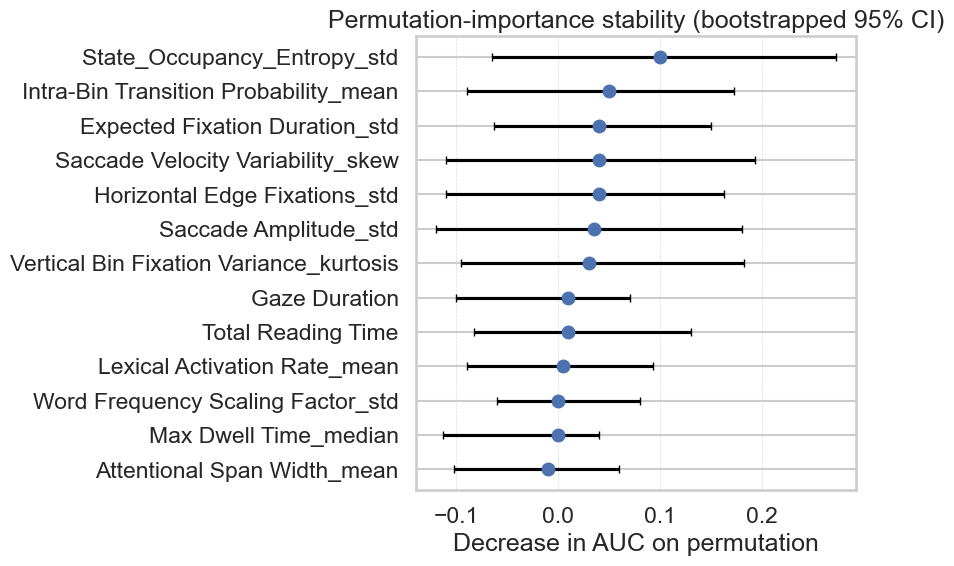

2025-05-10 18:10:34,212 INFO Figure saved: D:\ACIT Master's Thesis\New data\Figures\pdp_Total_Reading_Time.png & D:\ACIT Master's Thesis\New data\Figures\pdp_Total_Reading_Time.pdf


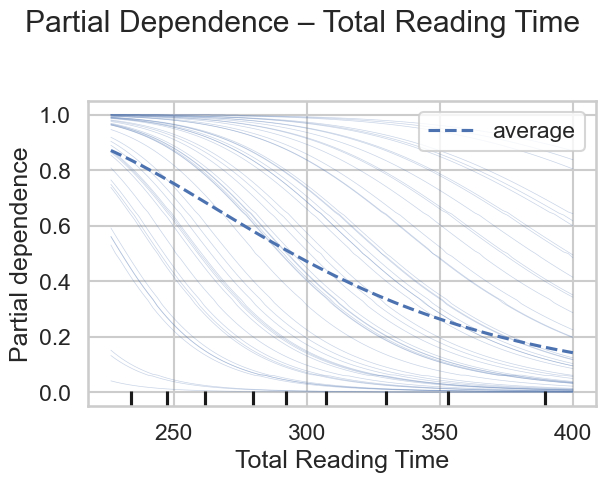

2025-05-10 18:10:36,714 INFO Figure saved: D:\ACIT Master's Thesis\New data\Figures\pdp_Gaze_Duration.png & D:\ACIT Master's Thesis\New data\Figures\pdp_Gaze_Duration.pdf


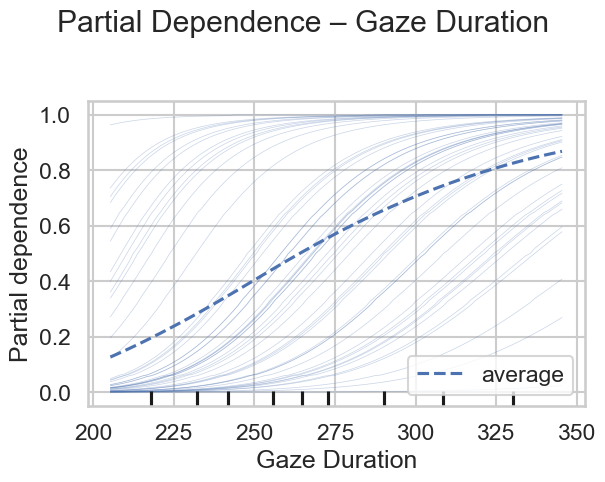

2025-05-10 18:10:39,153 INFO Figure saved: D:\ACIT Master's Thesis\New data\Figures\pdp_Saccade_Amplitude_std.png & D:\ACIT Master's Thesis\New data\Figures\pdp_Saccade_Amplitude_std.pdf


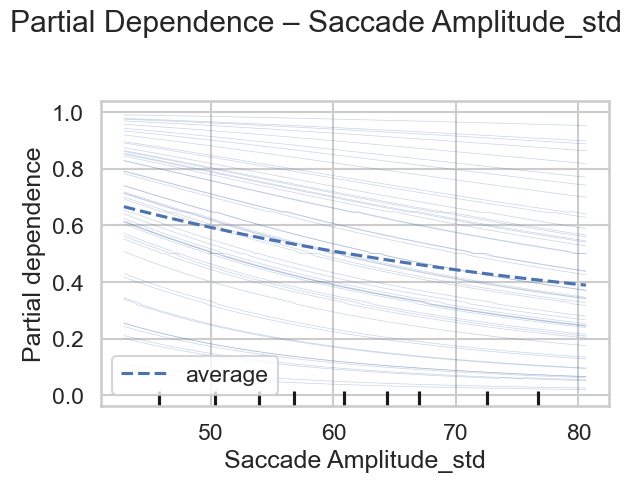

2025-05-10 18:10:39,666 INFO Computing SHAP importance...


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:10:39,689 INFO num_full_subsets = 1
2025-05-10 18:10:39,689 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:10:39,690 INFO num_paired_subset_sizes = 6
2025-05-10 18:10:39,697 INFO weight_left = 0.6508991990327944
2025-05-10 18:10:39,730 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 18:10:39,731 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 18:10:39,735 INFO phi = array([-0.1075164 ,  0.1840882 , -0.04004004, -0.03758154,  0.        ,
       -0.02299912, -0.35164649,  0.14426681,  0.05824827,  0.        ,
       -0.0807182 ,  0.03587945,  0.        ])
2025-05-10 18:10:39,741 INFO num_full_subsets = 1
2025-05-10 18:10:39,742 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:10:39,743 INFO num_paired_subset_sizes = 6
2025-05-10 18:10:39,752 INFO weight_left = 0.6508991990327944
2025-05-10 18:10:39,798 INFO np.sum(w_aug) = 13.000000000000004


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:10:47,037 INFO num_full_subsets = 1
2025-05-10 18:10:47,038 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:10:47,039 INFO num_paired_subset_sizes = 6
2025-05-10 18:10:47,047 INFO weight_left = 0.6508991990327944
2025-05-10 18:10:47,093 INFO np.sum(w_aug) = 13.000000000000004
2025-05-10 18:10:47,094 INFO np.sum(self.kernelWeights) = 0.9999999999999999
2025-05-10 18:10:47,100 INFO phi = array([ 0.        ,  0.01067001, -0.09420698,  0.09461188,  0.11673785,
       -0.04404718, -0.14340714,  0.        ,  0.03598185, -0.03508517,
        0.        ,  0.05833193, -0.02951612])
2025-05-10 18:10:47,108 INFO num_full_subsets = 1
2025-05-10 18:10:47,109 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:10:47,110 INFO num_paired_subset_sizes = 6
2025-05-10 18:10:47,118 INFO weight_left = 0.6508991990327944
2025-05-10 18:10:47,167 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:10:54,117 INFO num_full_subsets = 1
2025-05-10 18:10:54,118 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:10:54,119 INFO num_paired_subset_sizes = 6
2025-05-10 18:10:54,127 INFO weight_left = 0.6508991990327944
2025-05-10 18:10:54,175 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 18:10:54,176 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 18:10:54,183 INFO phi = array([ 0.0746244 ,  0.03679843,  0.        ,  0.        , -0.07844362,
        0.        , -0.044477  ,  0.17923819,  0.2746435 , -0.16803514,
        0.05784194, -0.10456266,  0.08908446])
2025-05-10 18:10:54,191 INFO num_full_subsets = 1
2025-05-10 18:10:54,192 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:10:54,193 INFO num_paired_subset_sizes = 6
2025-05-10 18:10:54,201 INFO weight_left = 0.6508991990327944
2025-05-10 18:10:54,250 INFO np.sum(w_aug) = 13.000000000000002


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:11:01,144 INFO num_full_subsets = 1
2025-05-10 18:11:01,145 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:01,145 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:01,153 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:01,204 INFO np.sum(w_aug) = 13.0
2025-05-10 18:11:01,205 INFO np.sum(self.kernelWeights) = 0.9999999999999999
2025-05-10 18:11:01,210 INFO phi = array([-0.05277914, -0.09619318,  0.        , -0.05690383, -0.09711179,
        0.04754798, -0.12600838,  0.25996925,  0.14931585,  0.        ,
        0.        , -0.11948894,  0.1350316 ])
2025-05-10 18:11:01,217 INFO num_full_subsets = 1
2025-05-10 18:11:01,217 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:01,218 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:01,226 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:01,275 INFO np.sum(w_aug) = 13.000000000000002

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:11:08,372 INFO num_full_subsets = 1
2025-05-10 18:11:08,372 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:08,374 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:08,382 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:08,425 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 18:11:08,426 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 18:11:08,430 INFO phi = array([-0.03253578,  0.11336006, -0.08276532,  0.        ,  0.        ,
        0.03138154,  0.08997716, -0.03438344,  0.14775729, -0.01974834,
       -0.0236061 ,  0.04430972,  0.        ])
2025-05-10 18:11:08,435 INFO num_full_subsets = 1
2025-05-10 18:11:08,437 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:08,438 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:08,444 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:08,488 INFO np.sum(w_aug) = 13.0
2025-05-10 18:

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:11:15,878 INFO num_full_subsets = 1
2025-05-10 18:11:15,879 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:15,881 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:15,889 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:15,944 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 18:11:15,945 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 18:11:15,951 INFO phi = array([ 0.10046882,  0.03830991, -0.04722954, -0.03102956,  0.        ,
        0.20789153, -0.39540201,  0.15169359,  0.        ,  0.23086323,
       -0.06994139,  0.        , -0.0526045 ])
2025-05-10 18:11:15,959 INFO num_full_subsets = 1
2025-05-10 18:11:15,961 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:15,961 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:15,968 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:16,022 INFO np.sum(w_aug) = 13.0
2025-05-10 18:

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:11:23,746 INFO num_full_subsets = 1
2025-05-10 18:11:23,750 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:23,750 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:23,758 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:23,821 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 18:11:23,823 INFO np.sum(self.kernelWeights) = 0.9999999999999999
2025-05-10 18:11:23,825 INFO phi = array([ 0.15858051, -0.01867981,  0.        ,  0.        ,  0.01523689,
        0.        , -0.14251294,  0.22962365,  0.3268412 , -0.21806098,
        0.01919282, -0.09190639,  0.0331881 ])
2025-05-10 18:11:23,832 INFO num_full_subsets = 1
2025-05-10 18:11:23,836 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:23,836 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:23,846 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:23,894 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:11:31,668 INFO num_full_subsets = 1
2025-05-10 18:11:31,668 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:31,668 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:31,677 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:31,731 INFO np.sum(w_aug) = 13.0
2025-05-10 18:11:31,731 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 18:11:31,735 INFO phi = array([-0.16187597,  0.        ,  0.        ,  0.10356024, -0.08339049,
        0.        ,  0.15163307, -0.09924314, -0.24678163,  0.12565651,
        0.04580729,  0.0297383 , -0.04116445])
2025-05-10 18:11:31,735 INFO num_full_subsets = 1
2025-05-10 18:11:31,747 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:31,747 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:31,750 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:31,801 INFO np.sum(w_aug) = 13.0
2025-05-10 18:11:31,802 INFO

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:11:39,546 INFO num_full_subsets = 1
2025-05-10 18:11:39,546 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:39,548 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:39,559 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:39,607 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 18:11:39,607 INFO np.sum(self.kernelWeights) = 1.0000000000000002
2025-05-10 18:11:39,615 INFO phi = array([ 0.        ,  0.09978034,  0.00741252,  0.03530005,  0.05656818,
       -0.12323303,  0.        , -0.06294555, -0.06167328,  0.17476141,
        0.07141732,  0.03815192,  0.        ])
2025-05-10 18:11:39,628 INFO num_full_subsets = 1
2025-05-10 18:11:39,628 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:39,630 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:39,638 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:39,693 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:11:47,450 INFO num_full_subsets = 1
2025-05-10 18:11:47,452 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:47,452 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:47,457 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:47,506 INFO np.sum(w_aug) = 13.000000000000004
2025-05-10 18:11:47,506 INFO np.sum(self.kernelWeights) = 0.9999999999999999
2025-05-10 18:11:47,512 INFO phi = array([-0.07913102,  0.        ,  0.06858455, -0.08273152,  0.        ,
        0.06234112, -0.13001743,  0.24942806,  0.24587073, -0.31871962,
        0.08899304,  0.        ,  0.0335921 ])
2025-05-10 18:11:47,518 INFO num_full_subsets = 1
2025-05-10 18:11:47,518 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:47,521 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:47,528 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:47,582 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:11:55,100 INFO num_full_subsets = 1
2025-05-10 18:11:55,100 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:55,100 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:55,111 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:55,167 INFO np.sum(w_aug) = 13.0
2025-05-10 18:11:55,167 INFO np.sum(self.kernelWeights) = 0.9999999999999999
2025-05-10 18:11:55,173 INFO phi = array([-0.04681049,  0.        , -0.08066923, -0.07841132,  0.        ,
       -0.04708932,  0.04874233,  0.06966158,  0.28764404, -0.34038196,
        0.07205712,  0.05970993,  0.        ])
2025-05-10 18:11:55,179 INFO num_full_subsets = 1
2025-05-10 18:11:55,179 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:11:55,179 INFO num_paired_subset_sizes = 6
2025-05-10 18:11:55,188 INFO weight_left = 0.6508991990327944
2025-05-10 18:11:55,239 INFO np.sum(w_aug) = 13.000000000000004

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:12:02,740 INFO num_full_subsets = 1
2025-05-10 18:12:02,741 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:02,741 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:02,750 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:02,803 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 18:12:02,804 INFO np.sum(self.kernelWeights) = 1.0000000000000002
2025-05-10 18:12:02,810 INFO phi = array([-0.07935076,  0.13323341,  0.09364107, -0.07171194,  0.        ,
        0.13033173,  0.15717444, -0.0752172 , -0.1575158 ,  0.20412099,
        0.        ,  0.03250708,  0.        ])
2025-05-10 18:12:02,818 INFO num_full_subsets = 1
2025-05-10 18:12:02,819 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:02,820 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:02,826 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:02,878 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:12:10,270 INFO num_full_subsets = 1
2025-05-10 18:12:10,271 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:10,271 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:10,279 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:10,336 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 18:12:10,337 INFO np.sum(self.kernelWeights) = 1.0000000000000004
2025-05-10 18:12:10,342 INFO phi = array([ 0.13978008, -0.04513478,  0.0662308 , -0.06562934, -0.07087706,
        0.19472193,  0.09616215,  0.        , -0.10909431,  0.16314399,
        0.        ,  0.02334064,  0.        ])
2025-05-10 18:12:10,348 INFO num_full_subsets = 1
2025-05-10 18:12:10,348 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:10,348 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:10,356 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:10,402 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:12:18,007 INFO num_full_subsets = 1
2025-05-10 18:12:18,008 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:18,009 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:18,018 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:18,069 INFO np.sum(w_aug) = 13.0
2025-05-10 18:12:18,070 INFO np.sum(self.kernelWeights) = 1.0000000000000002
2025-05-10 18:12:18,076 INFO phi = array([ 0.        , -0.15789548,  0.03794762,  0.04154743,  0.07682505,
       -0.04236919,  0.20223932, -0.24436475, -0.34980273,  0.14636578,
        0.        ,  0.        , -0.02354085])
2025-05-10 18:12:18,083 INFO num_full_subsets = 1
2025-05-10 18:12:18,084 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:18,086 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:18,091 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:18,144 INFO np.sum(w_aug) = 13.0
2025-05-10 18

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:12:25,744 INFO num_full_subsets = 1
2025-05-10 18:12:25,746 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:25,746 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:25,752 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:25,801 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 18:12:25,801 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 18:12:25,807 INFO phi = array([ 0.        ,  0.02125741, -0.07952511,  0.        ,  0.05993753,
        0.03466952, -0.37391334, -0.05686113, -0.16869462,  0.2552186 ,
        0.        ,  0.02706746, -0.10191996])
2025-05-10 18:12:25,813 INFO num_full_subsets = 1
2025-05-10 18:12:25,815 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:25,815 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:25,824 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:25,879 INFO np.sum(w_aug) = 13.000000000000002


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:12:33,475 INFO num_full_subsets = 1
2025-05-10 18:12:33,477 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:33,477 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:33,484 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:33,534 INFO np.sum(w_aug) = 13.0
2025-05-10 18:12:33,534 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 18:12:33,539 INFO phi = array([-0.05677161,  0.        , -0.10945191, -0.10232198,  0.        ,
        0.        ,  0.04974669,  0.07129563,  0.31191053, -0.37514573,
        0.06382125,  0.03858799,  0.05278181])
2025-05-10 18:12:33,547 INFO num_full_subsets = 1
2025-05-10 18:12:33,548 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:33,548 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:33,557 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:33,599 INFO np.sum(w_aug) = 13.000000000000004
2025-05-10 18:

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:12:41,185 INFO num_full_subsets = 1
2025-05-10 18:12:41,187 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:41,188 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:41,194 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:41,250 INFO np.sum(w_aug) = 13.000000000000004
2025-05-10 18:12:41,252 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 18:12:41,257 INFO phi = array([ 0.07942001, -0.08794261, -0.05916831,  0.        ,  0.        ,
       -0.04072084,  0.10218163, -0.00765263,  0.18657345, -0.03397749,
        0.        , -0.12565623,  0.1199544 ])
2025-05-10 18:12:41,265 INFO num_full_subsets = 1
2025-05-10 18:12:41,265 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:41,268 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:41,272 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:41,329 INFO np.sum(w_aug) = 13.0
2025-05-10 18:

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:12:49,014 INFO num_full_subsets = 1
2025-05-10 18:12:49,014 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:49,014 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:49,024 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:49,077 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 18:12:49,077 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 18:12:49,083 INFO phi = array([ 0.11162132, -0.03193123,  0.        ,  0.13732572,  0.        ,
       -0.18873528,  0.24736753, -0.13010239,  0.36601144, -0.20053799,
        0.        , -0.08944764,  0.0877927 ])
2025-05-10 18:12:49,092 INFO num_full_subsets = 1
2025-05-10 18:12:49,095 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:49,095 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:49,099 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:49,153 INFO np.sum(w_aug) = 13.0
2025-05-10 18:

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:12:56,821 INFO num_full_subsets = 1
2025-05-10 18:12:56,821 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:56,826 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:56,832 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:56,884 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 18:12:56,884 INFO np.sum(self.kernelWeights) = 0.9999999999999999
2025-05-10 18:12:56,890 INFO phi = array([ 0.14072808, -0.20581452,  0.01756295,  0.        ,  0.15834715,
       -0.17414922,  0.05032846, -0.26555205,  0.        , -0.15263762,
        0.10840047,  0.02624721,  0.        ])
2025-05-10 18:12:56,896 INFO num_full_subsets = 1
2025-05-10 18:12:56,898 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:12:56,898 INFO num_paired_subset_sizes = 6
2025-05-10 18:12:56,906 INFO weight_left = 0.6508991990327944
2025-05-10 18:12:56,965 INFO np.sum(w_aug) = 13.0

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:13:04,558 INFO num_full_subsets = 1
2025-05-10 18:13:04,559 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:13:04,561 INFO num_paired_subset_sizes = 6
2025-05-10 18:13:04,569 INFO weight_left = 0.6508991990327944
2025-05-10 18:13:04,617 INFO np.sum(w_aug) = 13.0
2025-05-10 18:13:04,618 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 18:13:04,624 INFO phi = array([-0.04478989,  0.        ,  0.        ,  0.07081718,  0.02845654,
       -0.11779895,  0.06947314, -0.20967499, -0.3190979 ,  0.30813158,
        0.        ,  0.16062543, -0.12221281])
2025-05-10 18:13:04,632 INFO num_full_subsets = 1
2025-05-10 18:13:04,633 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:13:04,634 INFO num_paired_subset_sizes = 6
2025-05-10 18:13:04,641 INFO weight_left = 0.6508991990327944
2025-05-10 18:13:04,695 INFO np.sum(w_aug) = 13.0
2025-05-10 18:13:04,695 INFO

  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:13:11,998 INFO num_full_subsets = 1
2025-05-10 18:13:11,999 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:13:11,999 INFO num_paired_subset_sizes = 6
2025-05-10 18:13:12,010 INFO weight_left = 0.6508991990327944
2025-05-10 18:13:12,064 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 18:13:12,065 INFO np.sum(self.kernelWeights) = 0.9999999999999999
2025-05-10 18:13:12,069 INFO phi = array([ 0.17618327,  0.        ,  0.        ,  0.        , -0.12099815,
       -0.11860462,  0.09646667,  0.08449312,  0.25399982, -0.29526044,
       -0.0610718 , -0.12657993,  0.06376688])
2025-05-10 18:13:12,077 INFO num_full_subsets = 1
2025-05-10 18:13:12,078 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:13:12,079 INFO num_paired_subset_sizes = 6
2025-05-10 18:13:12,087 INFO weight_left = 0.6508991990327944
2025-05-10 18:13:12,145 INFO np.sum(w_aug) = 13.0

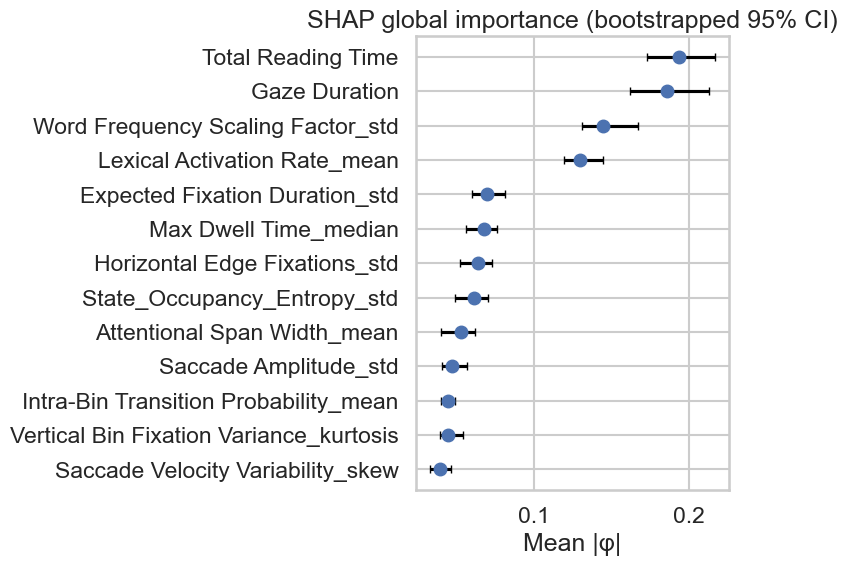

2025-05-10 18:13:26,882 INFO Figure saved: D:\ACIT Master's Thesis\New data\Figures\shap_summary_violin.png & D:\ACIT Master's Thesis\New data\Figures\shap_summary_violin.pdf


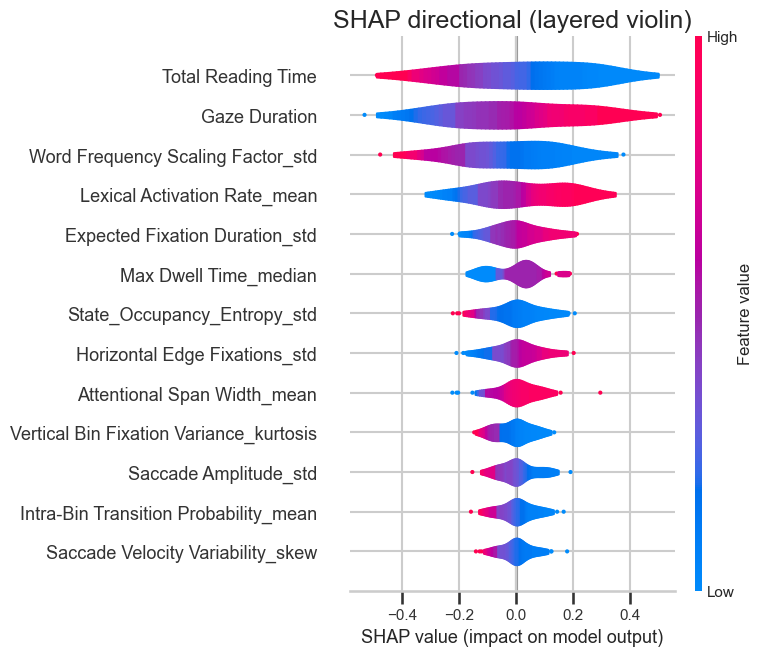

2025-05-10 18:13:30,719 INFO Figure saved: D:\ACIT Master's Thesis\New data\Figures\shap_summary_beeswarm.png & D:\ACIT Master's Thesis\New data\Figures\shap_summary_beeswarm.pdf


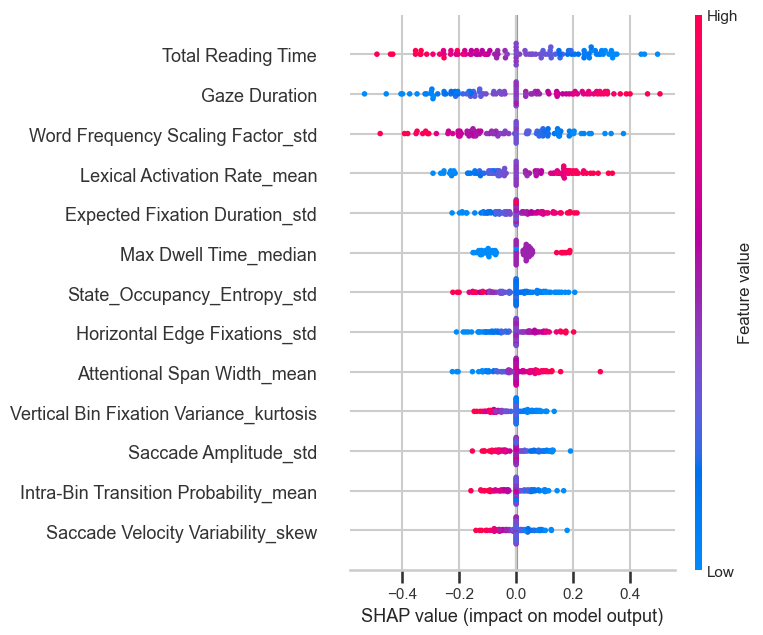

2025-05-10 18:13:31,201 INFO Computing SHAP interactions...


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 18:13:31,220 INFO num_full_subsets = 1
2025-05-10 18:13:31,221 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:13:31,222 INFO num_paired_subset_sizes = 6
2025-05-10 18:13:31,227 INFO weight_left = 0.6508991990327944
2025-05-10 18:13:31,269 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 18:13:31,270 INFO np.sum(self.kernelWeights) = 1.0000000000000004
2025-05-10 18:13:31,274 INFO phi = array([-0.11320987,  0.15737454, -0.03367365, -0.03844881,  0.02779395,
        0.        , -0.33688249,  0.11898323,  0.04325261,  0.        ,
       -0.09293468,  0.04972611,  0.        ])
2025-05-10 18:13:31,281 INFO num_full_subsets = 1
2025-05-10 18:13:31,281 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:13:31,282 INFO num_paired_subset_sizes = 6
2025-05-10 18:13:31,290 INFO weight_left = 0.6508991990327944
2025-05-10 18:13:31,330 INFO np.sum(w_aug) = 13.0

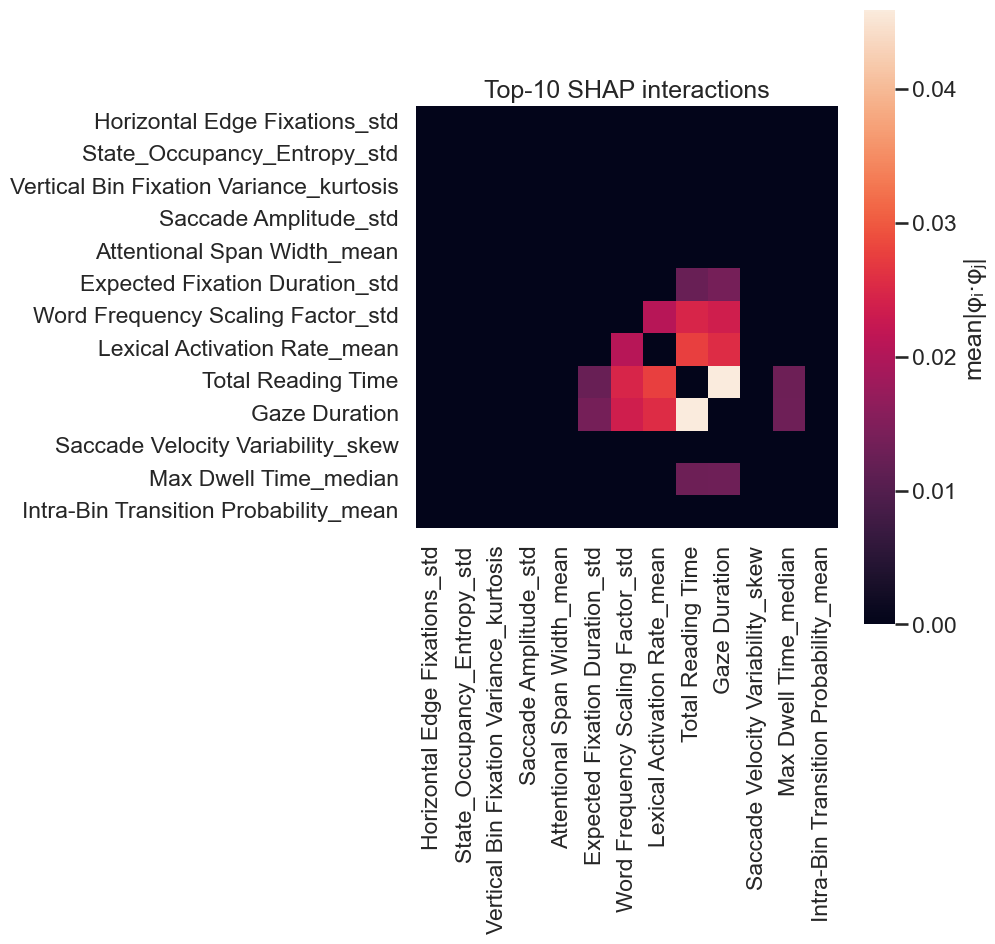

  0%|          | 0/3 [00:00<?, ?it/s]

2025-05-10 18:13:41,666 INFO num_full_subsets = 1
2025-05-10 18:13:41,667 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:13:41,668 INFO num_paired_subset_sizes = 6
2025-05-10 18:13:41,675 INFO weight_left = 0.6508991990327944
2025-05-10 18:13:41,764 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 18:13:41,765 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 18:13:41,771 INFO phi = array([ 0.        , -0.07447907, -0.07094077, -0.02281038, -0.05016632,
        0.        ,  0.16757219, -0.06334725, -0.05890136, -0.15779663,
       -0.07769487, -0.09107319,  0.        ])
2025-05-10 18:13:41,780 INFO num_full_subsets = 1
2025-05-10 18:13:41,781 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 18:13:41,782 INFO num_paired_subset_sizes = 6
2025-05-10 18:13:41,789 INFO weight_left = 0.6508991990327944
2025-05-10 18:13:41,881 INFO np.sum(w_aug) = 13.0
2025-05-10 18:

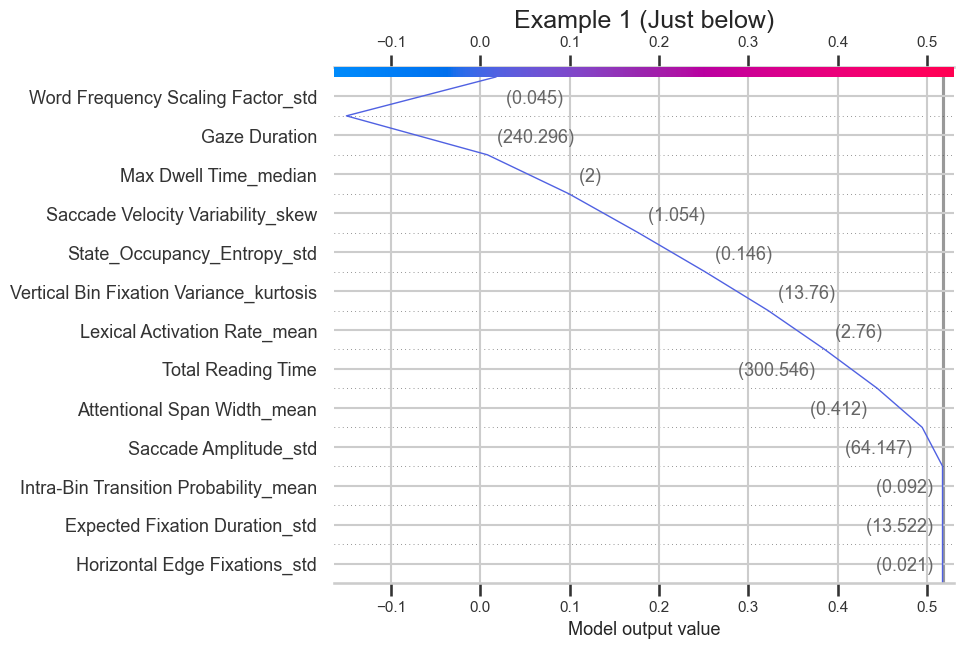

2025-05-10 18:13:46,117 INFO Figure saved: D:\ACIT Master's Thesis\New data\Figures\decision_Example_2_Near_threshold.png & D:\ACIT Master's Thesis\New data\Figures\decision_Example_2_Near_threshold.pdf


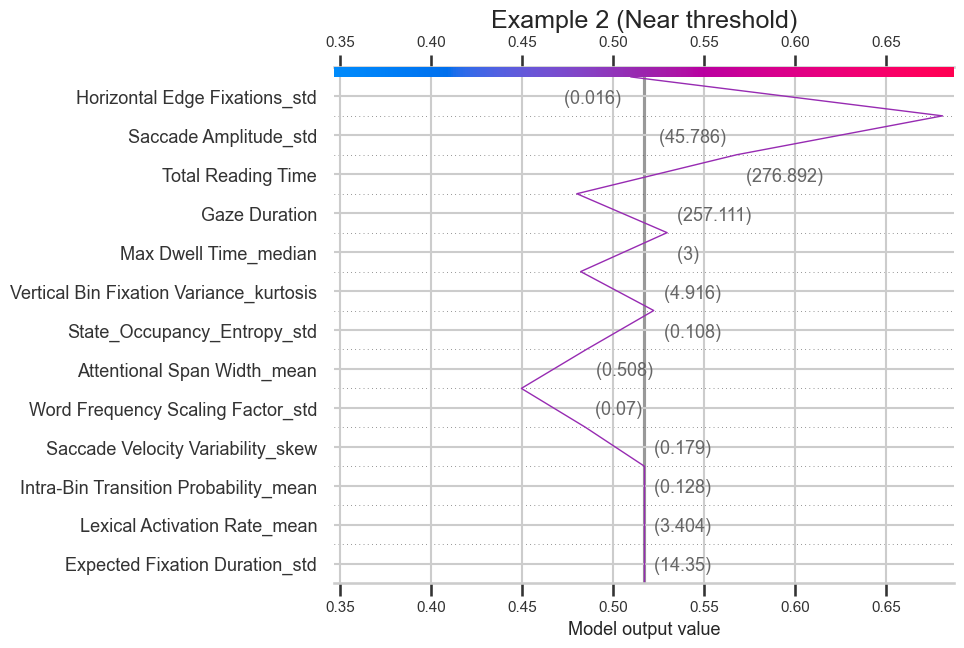

2025-05-10 18:13:48,326 INFO Figure saved: D:\ACIT Master's Thesis\New data\Figures\decision_Example_3_Just_above.png & D:\ACIT Master's Thesis\New data\Figures\decision_Example_3_Just_above.pdf


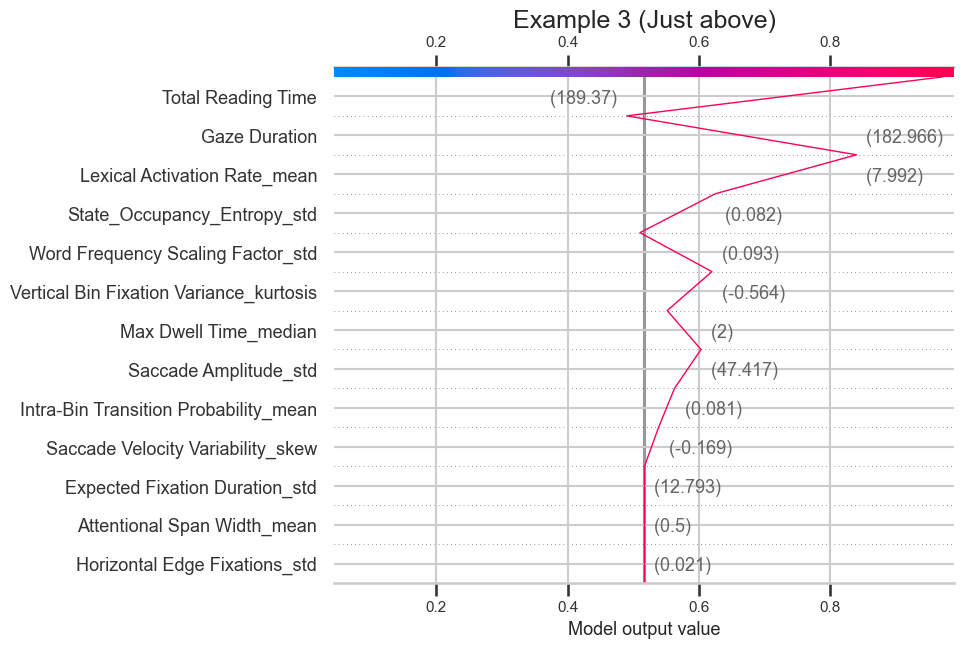

2025-05-10 18:13:48,804 INFO Model & threshold saved to svm_pipeline_full_accuracy_tuned.pkl


In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Extended SVM analysis with nested cross‑validation, permutation importance,
partial‑dependence plots, SHAP explanations (global, directional, stability),
feature interactions, and local decision‑plot sanity checks.
High‑quality PNG + PDF outputs saved at 300 dpi.
"""
from __future__ import annotations

import argparse
import logging
import warnings
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

# ----------------------------------------------------------------------------
# CONFIG & LOGGING
# ----------------------------------------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

DATA_PATH = Path(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv")
FIG_DIR   = Path(r"D:/ACIT Master's Thesis/New data/Figures")

FIG_DIR.mkdir(parents=True, exist_ok=True)
DEFAULT_DPI = 300

FEATURES: list[str] = [
    "Horizontal Edge Fixations_std", "State_Occupancy_Entropy_std",
    "Vertical Bin Fixation Variance_kurtosis", "Saccade Amplitude_std",
    "Attentional Span Width_mean", "Expected Fixation Duration_std",
    "Word Frequency Scaling Factor_std", "Lexical Activation Rate_mean",
    "Total Reading Time", "Gaze Duration", "Saccade Velocity Variability_skew",
    "Max Dwell Time_median", "Intra-Bin Transition Probability_mean",
]
GROUPS = {
    # (unchanged)
}
TARGET = "Group"
RANDOM_STATE = 42
OUT_MODEL = "svm_pipeline_full_accuracy_tuned.pkl"

sns.set_theme(style="whitegrid", context="talk")

# ----------------------------------------------------------------------------
# UTILITIES
# ----------------------------------------------------------------------------
def save_fig(fig: plt.Figure, name: str, dpi: int = DEFAULT_DPI) -> None:
    """
    Save *fig* under FIG_DIR as PNG + PDF.
    """
    png_path = FIG_DIR / f"{name}.png"
    pdf_path = FIG_DIR / f"{name}.pdf"
    fig.savefig(png_path, dpi=dpi, bbox_inches="tight")
    fig.savefig(pdf_path, bbox_inches="tight")
    log.info("Figure saved: %s & %s", png_path, pdf_path)

# ----------------------------------------------------------------------------
# PIPELINE & NESTED‑CV
# ----------------------------------------------------------------------------
def build_pipeline(with_smote: bool = True) -> Pipeline:
    steps: list[tuple[str, object]] = [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
    ]
    if with_smote:
        steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
    steps.append(("clf", SVC(probability=True,
                              class_weight="balanced",
                              random_state=RANDOM_STATE)))
    return Pipeline(steps)


def nested_cv_evaluate(X: np.ndarray, y: np.ndarray):
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)

    param_grid = {
        "clf__kernel": ["linear", "rbf"],
        "clf__C": [0.1, 1, 10, 100],
        "clf__gamma": ["scale", "auto"],
    }

    grid = GridSearchCV(build_pipeline(), param_grid,
                        scoring="roc_auc", cv=inner,
                        n_jobs=-1, refit=True)
    aucs = []
    all_probs = np.zeros(len(y))
    for fold, (tr, te) in enumerate(outer.split(X, y), start=1):
        grid.fit(X[tr], y[tr])
        probs = grid.predict_proba(X[te])[:, 1]
        all_probs[te] = probs
        fpr, tpr, _ = roc_curve(y[te], probs)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
        log.info("Fold %d: AUC = %.3f", fold, fold_auc)

    mean_auc, lo, hi = np.mean(aucs), *np.percentile(aucs, [2.5, 97.5])
    log.info("Nested‑CV AUC: %.3f (95%% CI %.3f–%.3f)", mean_auc, lo, hi)

    grid.fit(X, y)
    log.info("Final best params: %s", grid.best_params_)
    return grid.best_estimator_, 0.5

# ----------------------------------------------------------------------------
# PERMUTATION IMPORTANCE (quick) & STABILITY
# ----------------------------------------------------------------------------
def compute_permutation_importance(X: np.ndarray, y: np.ndarray, n_repeats: int = 5):
    """
    Quick bootstrap permutation importance.
    """
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    rng = np.random.RandomState(RANDOM_STATE)

    for fold, (tr, te) in enumerate(outer.split(X, y), start=1):
        seeds = rng.randint(0, 2**31 - 1, size=n_repeats)
        def one_boot(seed):
            rs = np.random.RandomState(seed)
            idx = rs.randint(0, len(y[tr]), len(y[tr]))
            pipe = build_pipeline()
            pipe.fit(X[tr][idx], y[tr][idx])
            imp = permutation_importance(pipe, X[te], y[te],
                                         n_repeats=n_repeats,
                                         random_state=rs,
                                         scoring="roc_auc")
            return imp.importances_mean

        arr = np.vstack([one_boot(s) for s in seeds])
        df = pd.DataFrame(arr, columns=FEATURES)
        df.to_csv(FIG_DIR/f"perm_importance_bootstrap_fold{fold}.csv", index=False)
        log.info("Completed bootstrap fold %d", fold)


def compute_permutation_importance_stability(
    X: np.ndarray, y: np.ndarray, n_repeats: int = 30
):
    """
    Plot & save permutation-importance stability across folds using bootstrap CIs.
    """
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    all_importances = []

    # collect importances for each fold
    for fold, (tr, te) in enumerate(outer.split(X, y), start=1):
        pipe = build_pipeline()
        pipe.fit(X[tr], y[tr])
        imp = permutation_importance(
            pipe, X[te], y[te],
            n_repeats=n_repeats, random_state=RANDOM_STATE,
            scoring="roc_auc"
        )
        # transpose so each row is one bootstrap sample's importances
        all_importances.append(imp.importances.T)
        log.info("Fold %d perm-importance values collected", fold)

    # concatenate bootstrap samples: shape (folds*n_repeats, n_features)
    arr = np.vstack(all_importances)
    lower = np.percentile(arr, 2.5, axis=0)
    median = np.percentile(arr, 50, axis=0)
    upper = np.percentile(arr, 97.5, axis=0)
    order = np.argsort(median)[::-1]

    # plot median with CIs
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.errorbar(
        median[order], [FEATURES[i] for i in order],
        xerr=[median[order] - lower[order], upper[order] - median[order]],
        fmt='o', color='#4c72b0', ecolor='black', capsize=3
    )
    ax.invert_yaxis()
    ax.set_title("Permutation-importance stability (bootstrapped 95% CI)")
    ax.set_xlabel("Decrease in AUC on permutation")
    ax.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    save_fig(fig, "perm_importance_stability")
    plt.show()

# ----------------------------------------------------------------------------
# PARTIAL DEPENDENCE PLOTS
# ----------------------------------------------------------------------------
def plot_partial_dependence(
    estimator: Pipeline, df_X: pd.DataFrame, features: list[str]
):
    """
    Generate PDPs for each feature (ICE + PDP).
    """
    for feat in features:
        disp = PartialDependenceDisplay.from_estimator(
            estimator, df_X, [feat], kind="both",
            subsample=50, random_state=RANDOM_STATE,
            grid_resolution=100,
        )
        disp.figure_.suptitle(f"Partial Dependence – {feat}", y=1.02)
        plt.tight_layout()
        save_fig(disp.figure_, f"pdp_{feat.replace(' ', '_')}" )
        plt.show()

# ----------------------------------------------------------------------------
# SHAP EXPLANATIONS: GLOBAL, DIRECTIONAL, STABILITY
# ----------------------------------------------------------------------------
def compute_shap_importance(pipeline: Pipeline, X: np.ndarray,
                            filename: str = "shap_summary",
                            bootstrap: bool = True, n_boot: int = 20):
    """
    SHAP summary: bar (mean|φ|) with bootstrap percentile CIs, beeswarm & violin.
    """
    # background for explainer
    bg = shap.sample(X, min(50, len(X)), random_state=RANDOM_STATE)
    explainer = shap.KernelExplainer(
        lambda d: pipeline.predict_proba(d)[:, 1], bg
    )
    shap_vals_all = explainer.shap_values(X, nsamples=200)
    vals = shap_vals_all[1] if isinstance(shap_vals_all, list) else shap_vals_all

    # compute bootstrap CIs if requested
    if bootstrap:
        rng = np.random.RandomState(RANDOM_STATE)
        boot_means = []
        for _ in range(n_boot):
            idx = rng.choice(len(X), len(X), replace=True)
            vals_b = explainer.shap_values(X[idx], nsamples=200)
            v = vals_b[1] if isinstance(vals_b, list) else vals_b
            boot_means.append(np.abs(v).mean(0))
        arr = np.vstack(boot_means)
        lower = np.percentile(arr, 2.5, axis=0)
        median = np.percentile(arr, 50, axis=0)
        upper = np.percentile(arr, 97.5, axis=0)
        df_ci = pd.DataFrame({
            'Feature': FEATURES,
            'CI_lower': lower,
            'Median': median,
            'CI_upper': upper
        }).sort_values('Median', ascending=False)
        df_ci.to_csv(FIG_DIR/f"{filename}_bootstrap_CI.csv", index=False)
        log.info("Saved SHAP bootstrap CI stats")
    else:
        # median equals mean if no bootstrap
        median = np.abs(vals).mean(0)
        df_ci = pd.DataFrame({
            'Feature': FEATURES,
            'CI_lower': median,
            'Median': median,
            'CI_upper': median
        }).sort_values('Median', ascending=False)

    # save overall mean|φ|
    df_global = pd.DataFrame({"Feature": FEATURES,
                              "Mean|φ|": np.abs(vals).mean(0)})
    df_global = df_global.sort_values("Mean|φ|", ascending=False)
    df_global.to_csv(FIG_DIR/f"{filename}_global.csv", index=False)

    # plot global importance with bootstrap CIs
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.errorbar(
        df_ci['Median'], df_ci['Feature'],
        xerr=[df_ci['Median'] - df_ci['CI_lower'], df_ci['CI_upper'] - df_ci['Median']],
        fmt='o', color='#4c72b0', ecolor='black', capsize=3
    )
    ax.invert_yaxis()
    ax.set_title("SHAP global importance (bootstrapped 95% CI)")
    ax.set_xlabel("Mean |φ|")
    plt.tight_layout(); save_fig(fig, f"{filename}_bar"); plt.show()

    # Directionality: violin & beeswarm
    fig = shap.summary_plot(vals, X, feature_names=FEATURES,
                            plot_type="violin", show=False)
    plt.title("SHAP directional (layered violin)")
    save_fig(plt.gcf(), f"{filename}_violin"); plt.show()
    shap.summary_plot(vals, X, feature_names=FEATURES,
                      plot_type="dot", show=False)
    save_fig(plt.gcf(), f"{filename}_beeswarm"); plt.show()

# ----------------------------------------------------------------------------
# SHAP INTERACTIONS (TOP‑K HEATMAP)
# ----------------------------------------------------------------------------
def compute_shap_interactions(
    pipeline: Pipeline, X: np.ndarray, max_display: int = 10
):
    bg = shap.sample(X, min(50, len(X)), random_state=RANDOM_STATE)
    explainer = shap.KernelExplainer(
        lambda d: pipeline.predict_proba(d)[:, 1], bg
    )
    shap_vals = explainer.shap_values(X, nsamples=200)
    vals = shap_vals[1] if isinstance(shap_vals, list) else shap_vals
    p = vals.shape[1]
    inter = np.zeros((p, p))
    for i in range(p):
        for j in range(i+1, p):
            inter[i, j] = inter[j, i] = np.abs(vals[:, i] * vals[:, j]).mean()
    pairs = [((i, j), inter[i, j]) for i in range(p) for j in range(i+1, p)]
    top = sorted(pairs, key=lambda x: x[1], reverse=True)[:max_display]
    H = np.zeros_like(inter)
    for (i, j), v in top:
        H[i, j] = H[j, i] = v
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(H, xticklabels=FEATURES, yticklabels=FEATURES,
                square=True, cbar_kws={"label": "mean|φᵢ·φⱼ|"}, ax=ax)
    ax.set_title(f"Top-{max_display} SHAP interactions")
    plt.tight_layout(); save_fig(fig, "shap_interactions"); plt.show()

# ----------------------------------------------------------------------------
# LOCAL SANITY CHECKS (DECISION PLOTS)
# ----------------------------------------------------------------------------
def local_sanity_checks(
    pipeline: Pipeline, X: np.ndarray, y: np.ndarray,
    threshold: float = 0.5, n_cases: int = 3
):
    """
    Generate decision plots for illustrative examples (Academic labels).
    """
    probs = pipeline.predict_proba(X)[:, 1]
    diffs = probs - threshold
    # select three examples: below, near, above threshold
    idxs = [np.argsort(diffs)[0], np.argsort(np.abs(diffs))[0], np.argsort(diffs)[-1]]
    labels = ["Example 1 (Just below)", "Example 2 (Near threshold)", "Example 3 (Just above)"]

    # background for explainer
    bg = shap.sample(X, min(200, len(X)), random_state=RANDOM_STATE)
    explainer = shap.KernelExplainer(
        lambda d: pipeline.predict_proba(d)[:, 1], bg
    )
    shap_vals_all = explainer.shap_values(X[idxs], nsamples=200)
    if isinstance(shap_vals_all, list):
        shap_vals = shap_vals_all[1]
        expected = explainer.expected_value[1]
    else:
        shap_vals = shap_vals_all
        expected = explainer.expected_value

    for label, k, sv in zip(labels, idxs, shap_vals):
        shap.decision_plot(
            expected, sv, X[k],
            feature_names=FEATURES,
            show=False
        )
        fig = plt.gcf()
        plt.title(f"{label}")
        save_fig(fig, f"decision_{label.replace(' ', '_').replace('(', '').replace(')', '')}")
        plt.show()

# ----------------------------------------------------------------------------
def main() -> None:
    parser = argparse.ArgumentParser(
        description="Extended SVM analysis with nested CV, permutation, PDP, SHAP"
    )
    parser.add_argument("--data-path", type=Path, default=DATA_PATH)
    args, _ = parser.parse_known_args()

    df = pd.read_csv(args.data_path)
    X = df[FEATURES].values
    y = LabelEncoder().fit_transform(df[TARGET])

    pipe, thr = nested_cv_evaluate(X, y)

    # Permutation importance
    compute_permutation_importance(X, y)
    compute_permutation_importance_stability(X, y)

    # PDPs
    PDP_FEATURES = ["Total Reading Time", "Gaze Duration", "Saccade Amplitude_std"]
    plot_partial_dependence(pipe, df[FEATURES], PDP_FEATURES)

    # SHAP explanations
    log.info("Computing SHAP importance...")
    compute_shap_importance(pipe, X)
    log.info("Computing SHAP interactions...")
    compute_shap_interactions(pipe, X)

    # Local sanity
    local_sanity_checks(pipe, X, y, threshold=thr, n_cases=3)

    joblib.dump({"pipeline": pipe, "threshold": thr}, OUT_MODEL)
    log.info("Model & threshold saved to %s", OUT_MODEL)

if __name__ == "__main__":
    main()
